In [450]:
import praw
import pandas as pd
import re
import time
from datetime import datetime
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [465]:
# === CONFIGURATION ===

# Reddit Authentication - fill these in with your credentials
REDDIT_CLIENT_ID = "suCjVen6MTRiU9E88cqRAg"
REDDIT_CLIENT_SECRET = "UiP81w6C1qyenfZzJ0asiegtJlQtZA"
REDDIT_USER_AGENT = "ECE473 Final Project"

reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
)

# Subreddits to scrape
SUBREDDITS = ["CryptoCurrency", "CryptoMoonShots", "altcoin", "CryptoMarkets", "OfficialTrumpCoin"]

# Regex pattern to match TrumpCoin mentions
TRUMP_REGEX = re.compile(r"(?i)\b(trump\s*coin|\$trump|trumpcoin)\b")

# Output CSV
OUTPUT_FILE = "reddit_trumpcoin_praw_filtered.csv"

# Target Time Window
START_DATE = datetime(2025, 1, 15)
END_DATE = datetime(2025, 4, 19)

# Max posts per subreddit to fetch
MAX_POSTS_PER_SUBREDDIT = 1500

# Sleep time between API calls
SLEEP_TIME = 0.5  # seconds

# === HELPER FUNCTIONS ===

def match_trumpcoin(text):
    """Check if text matches TrumpCoin regex."""
    if text:
        return bool(TRUMP_REGEX.search(text))
    return False

def utc_to_datetime(utc_timestamp):
    """Convert UTC timestamp to datetime object."""
    return datetime.utcfromtimestamp(utc_timestamp)

def is_within_date_range(utc_timestamp):
    """Check if the post/comment is within the target date window."""
    post_time = utc_to_datetime(utc_timestamp)
    return START_DATE <= post_time <= END_DATE

def extract_post_data(post):
    """Extract fields from a Reddit post."""
    return {
        "source": "post",
        "parent_id": post.id,
        "subreddit": post.subreddit.display_name,
        "author": str(post.author),
        "score": post.score,
        "created_utc": utc_to_datetime(post.created_utc),
        "text": (post.title or "") + " " + (post.selftext or ""),
        "permalink": f"https://reddit.com{post.permalink}"
    }

def extract_comment_data(comment, parent_id):
    """Extract fields from a Reddit comment."""
    return {
        "source": "comment",
        "parent_id": parent_id,
        "subreddit": comment.subreddit.display_name,
        "author": str(comment.author),
        "score": comment.score,
        "created_utc": utc_to_datetime(comment.created_utc),
        "text": comment.body,
        "permalink": f"https://reddit.com{comment.permalink}" if hasattr(comment, "permalink") else None
    }

# === MAIN SCRAPER ===

def main():
    all_data = []

    for subreddit_name in SUBREDDITS:
        print(f"Searching subreddit: {subreddit_name}")
        subreddit = reddit.subreddit(subreddit_name)

        # Search for TrumpCoin related posts
        for post in subreddit.search("trumpcoin OR \"trump coin\" OR $trump", sort="new", limit=MAX_POSTS_PER_SUBREDDIT):
            if not is_within_date_range(post.created_utc):
                continue  # Skip posts outside the date window
            post_text = (post.title or "") + " " + (post.selftext or "")
            
            if match_trumpcoin(post_text):
                all_data.append(extract_post_data(post))

                try:
                    post.comments.replace_more(limit=0)  # Load all comments
                    for comment in post.comments.list():
                        if is_within_date_range(comment.created_utc) and match_trumpcoin(comment.body):
                            all_data.append(extract_comment_data(comment, parent_id=post.id))
                except Exception as e:
                    print(f"Error fetching comments: {e}")

            time.sleep(SLEEP_TIME)

    # Save everything
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Saved {len(df)} records to {OUTPUT_FILE}")

# === ENTRY POINT ===

if __name__ == "__main__":
    main()


Searching subreddit: CryptoCurrency
Searching subreddit: CryptoMoonShots
Searching subreddit: altcoin
Searching subreddit: CryptoMarkets
Searching subreddit: OfficialTrumpCoin
Saved 205 records to reddit_trumpcoin_praw_filtered.csv


In [466]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# === INITIAL SETUP ===

# Load your scraped data
INPUT_FILE = "reddit_trumpcoin_praw_filtered.csv"
OUTPUT_FILE = "reddit_trumpcoin_sentiment.csv"

# Download VADER Lexicon (only need to do this once)
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Load the CSV
df = pd.read_csv(INPUT_FILE)

# === SENTIMENT ANALYSIS ===

# Function to compute VADER sentiment score
def get_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)['compound']
    else:
        return 0  # If text is NaN or not a string, return neutral

# Apply sentiment analysis to each row
df['sentiment_score'] = df['text'].apply(get_sentiment)

# Save the new DataFrame
df.to_csv(OUTPUT_FILE, index=False)

print(f"Saved sentiment-scored data to {OUTPUT_FILE}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ateye\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Saved sentiment-scored data to reddit_trumpcoin_sentiment.csv


In [469]:
# Load your sentiment-scored Reddit data
df = pd.read_csv("reddit_trumpcoin_sentiment.csv")

# Ensure created_utc is a datetime object
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Extract just the date part (drop time)
df['date'] = df['created_utc'].dt.date

# Group by date
daily_sentiment = df.groupby('date').agg(
    avg_sentiment=('sentiment_score', 'mean'),
    num_posts=('sentiment_score', 'count')
).reset_index()

# Save to CSV (optional)
daily_sentiment.to_csv("daily_sentiment.csv", index=False)

# Preview
print(daily_sentiment.head(60))


          date  avg_sentiment  num_posts
0   2025-01-18       0.995600          2
1   2025-01-19       0.996000          1
2   2025-01-20       0.529627         11
3   2025-01-21       0.146350         14
4   2025-01-22       0.383367          3
5   2025-01-23       0.457520          5
6   2025-01-24       0.722660          5
7   2025-01-25      -0.607200          1
8   2025-01-26      -0.040800          2
9   2025-01-27       0.224878          9
10  2025-01-30       0.972900          2
11  2025-02-01      -0.318200          1
12  2025-02-02       0.432200          5
13  2025-02-03      -0.053450          6
14  2025-02-04       0.129760          5
15  2025-02-05       0.194360          5
16  2025-02-06      -0.011633          3
17  2025-02-07       0.384967          3
18  2025-02-08      -0.950300          1
19  2025-02-09      -0.003271          7
20  2025-02-10       0.314267          3
21  2025-02-11      -0.076392         13
22  2025-02-12       0.014800          2
23  2025-02-13  

In [470]:
# Load your daily sentiment data
daily_sentiment = pd.read_csv("daily_sentiment.csv")

# === TRADING RULES ===

def generate_signal(avg_sentiment):
    if avg_sentiment > 0.05:
        return "LONG"
    elif avg_sentiment < -0.05:
        return "SHORT"
    else:
        return "HOLD"

# Apply trading rule
daily_sentiment['signal'] = daily_sentiment['avg_sentiment'].apply(generate_signal)

# Save to CSV (optional)
daily_sentiment.to_csv("daily_sentiment_signals.csv", index=False)

# Preview
print(daily_sentiment.head(60))

          date  avg_sentiment  num_posts signal
0   2025-01-18       0.995600          2   LONG
1   2025-01-19       0.996000          1   LONG
2   2025-01-20       0.529627         11   LONG
3   2025-01-21       0.146350         14   LONG
4   2025-01-22       0.383367          3   LONG
5   2025-01-23       0.457520          5   LONG
6   2025-01-24       0.722660          5   LONG
7   2025-01-25      -0.607200          1  SHORT
8   2025-01-26      -0.040800          2   HOLD
9   2025-01-27       0.224878          9   LONG
10  2025-01-30       0.972900          2   LONG
11  2025-02-01      -0.318200          1  SHORT
12  2025-02-02       0.432200          5   LONG
13  2025-02-03      -0.053450          6  SHORT
14  2025-02-04       0.129760          5   LONG
15  2025-02-05       0.194360          5   LONG
16  2025-02-06      -0.011633          3   HOLD
17  2025-02-07       0.384967          3   LONG
18  2025-02-08      -0.950300          1  SHORT
19  2025-02-09      -0.003271          7

In [473]:
# === CONFIGURATION ===

API_KEY = "5a69a69b336064e8f6c950f66d17ef5e08c727162f1c06e70e17722f8af024ef"  # <-- put your key here

# CryptoCompare endpoint for daily data
url = "https://min-api.cryptocompare.com/data/v2/histoday"

# TrumpCoin symbol
FSYM = "TRUMP"
# Quote currency
TSYM = "USDT"

# Time window
START_DATE = datetime(2025, 1, 15)
END_DATE = datetime(2025, 3, 31)

# Calculate how many days to request
days_diff = (END_DATE - START_DATE).days

# === API Request ===

params = {
    "fsym": FSYM,
    "tsym": TSYM,
    "limit": days_diff,   # number of data points - 1
    "toTs": int(END_DATE.timestamp()),
    "api_key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

# Check if request succeeded
if data['Response'] != 'Success':
    print("Error fetching data:", data)
    raise Exception("Failed to fetch price data.")

# Extract price data
price_data = data['Data']['Data']

# Convert to DataFrame
df_prices = pd.DataFrame(price_data)

# Convert timestamp to date
df_prices['date'] = pd.to_datetime(df_prices['time'], unit='s')
df_prices = df_prices[['date', 'close']]

# Save to CSV
df_prices.to_csv("trumpcoin_prices.csv", index=False)

print(df_prices.head(200))
print(f"Saved {len(df_prices)} days of TrumpCoin prices to trumpcoin_prices.csv")


         date  close
0  2025-01-15   0.00
1  2025-01-16   0.00
2  2025-01-17   0.00
3  2025-01-18   0.00
4  2025-01-19   0.00
..        ...    ...
71 2025-03-27  11.11
72 2025-03-28  10.35
73 2025-03-29  10.08
74 2025-03-30  10.22
75 2025-03-31  10.01

[76 rows x 2 columns]
Saved 76 days of TrumpCoin prices to trumpcoin_prices.csv


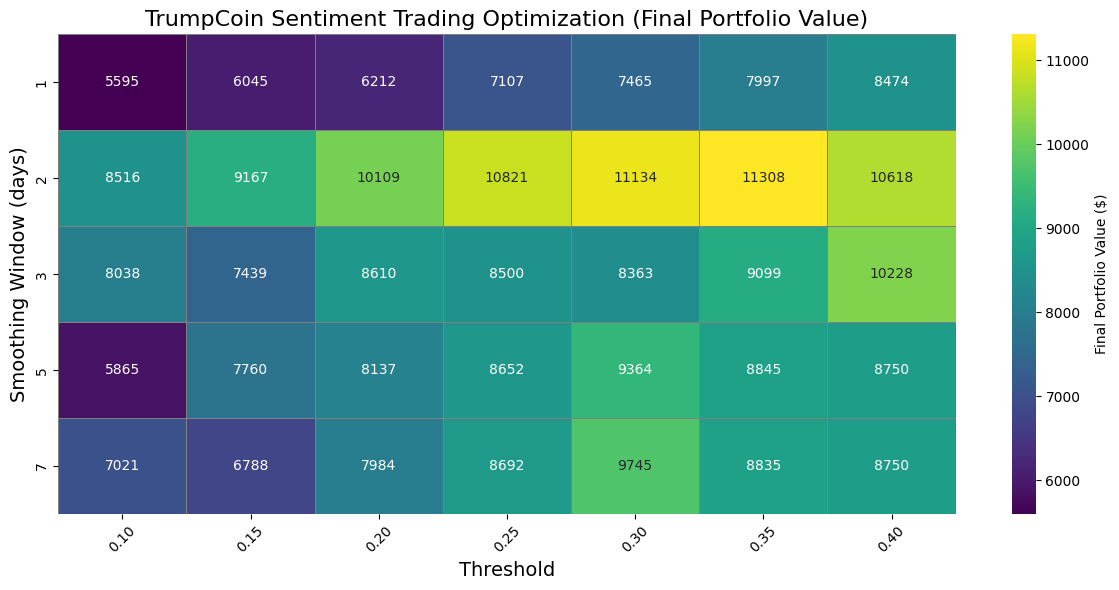

In [477]:
# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000  # Start with $10k
TRADE_PERCENT = 0.5         # 50% of portfolio used per trade

# === LOAD DATA ===

# Load raw daily sentiment
daily_sentiment = pd.read_csv("daily_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Load TrumpCoin prices
prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge sentiment and prices
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# === OPTIMIZATION ===

# Define parameter grid
smoothing_windows = [1, 2, 3, 5, 7]
thresholds = np.arange(0.1, 0.4, 0.05)  # 0.05, 0.10, 0.15, ..., 0.30

# Results storage
results = []

# Loop over parameters
for window in smoothing_windows:
    for threshold in thresholds:
        
        portfolio = STARTING_PORTFOLIO
        position = None
        entry_price = None
        trade_size = 0
        
        df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=window, min_periods=1).mean()

        def generate_signal(smoothed_sentiment):
            if smoothed_sentiment > threshold:
                return 'LONG'
            elif smoothed_sentiment < -threshold:
                return 'SHORT'
            else:
                return 'HOLD'

        df['signal'] = df['smoothed_sentiment'].apply(generate_signal)
        
        for i in range(1, len(df)):
            today = df.loc[i]
            yesterday = df.loc[i-1]
            
            today_price = today['close']
            if today_price == 0 or pd.isna(today_price):
                continue

            signal = yesterday['signal']

            if signal == 'LONG':
                if position == 'SHORT' and entry_price is not None:
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None
                if position != 'LONG':
                    trade_size = portfolio * TRADE_PERCENT
                    position = 'LONG'
                    entry_price = today_price

            elif signal == 'SHORT':
                if position == 'LONG' and entry_price is not None:
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None
                if position != 'SHORT':
                    trade_size = portfolio * TRADE_PERCENT
                    position = 'SHORT'
                    entry_price = today_price

            else:  # HOLD
                if position == 'LONG' and entry_price is not None:
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                elif position == 'SHORT' and entry_price is not None:
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                position = None
                entry_price = None

            # No need to track portfolio daily for optimization

        # Save result
        results.append({
            'smoothing_window': window,
            'threshold': threshold,
            'final_portfolio': portfolio
        })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV (optional)
results_df.to_csv("optimization_results.csv", index=False)

# === PLOT RESULTS ===

pivot_table = results_df.pivot(index='smoothing_window', columns='threshold', values='final_portfolio')

# === PLOT ===

plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, 
            annot=True, fmt=".0f", cmap="viridis",
            linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Final Portfolio Value ($)'})

plt.title('TrumpCoin Sentiment Trading Optimization (Final Portfolio Value)', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Smoothing Window (days)', fontsize=14)

# === FIX TICK LABELS ===

# Round the tick labels manually
plt.xticks(ticks=np.arange(len(pivot_table.columns)) + 0.5, 
           labels=[f"{x:.2f}" for x in pivot_table.columns], rotation=45)

plt.yticks(ticks=np.arange(len(pivot_table.index)) + 0.5, 
           labels=pivot_table.index)

plt.tight_layout()
plt.show()


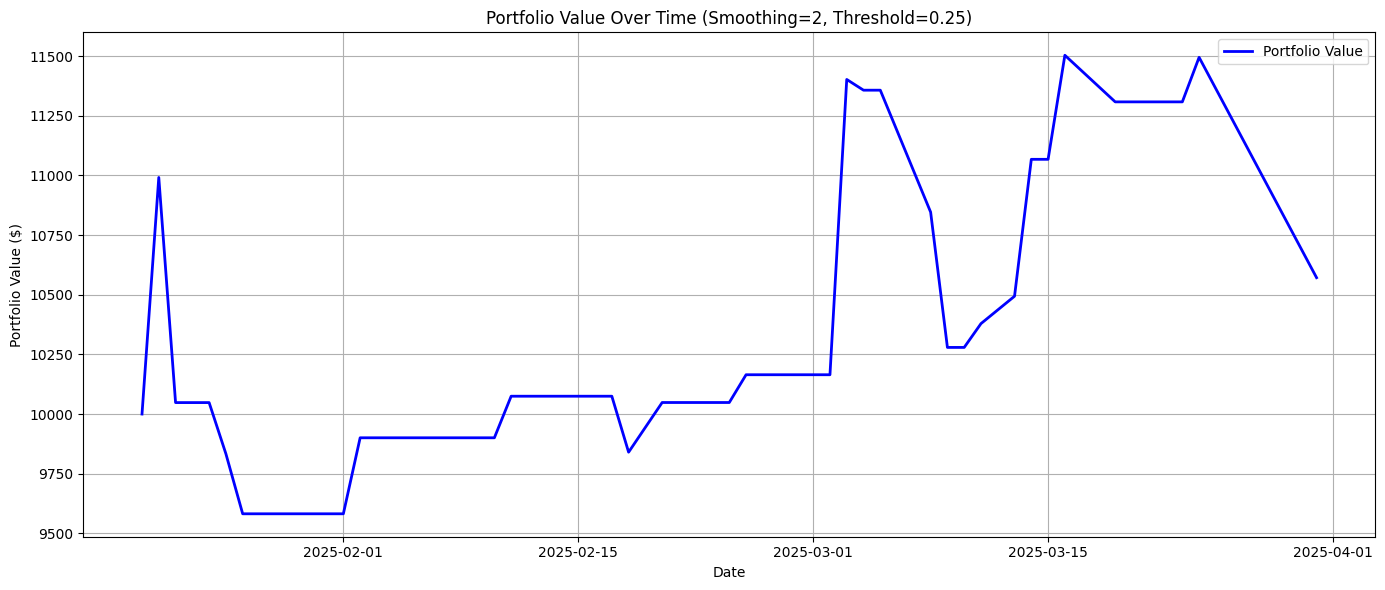

In [478]:
    # === CONFIGURATION ===

    STARTING_PORTFOLIO = 10000
    TRADE_PERCENT = 0.5
    SMOOTHING_WINDOW = 2
    SENTIMENT_THRESHOLD = 0.35

    # === LOAD DATA ===

    # Load sentiment and prices
    daily_sentiment = pd.read_csv("daily_sentiment.csv")
    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

    prices = pd.read_csv("trumpcoin_prices.csv")
    prices['date'] = pd.to_datetime(prices['date'])

    # Merge
    df = pd.merge(daily_sentiment, prices, on='date', how='inner')
    df = df.sort_values('date').reset_index(drop=True)

    # === APPLY SMOOTHING AND SIGNAL ===

    df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

    def generate_signal(smoothed_sentiment):
        if smoothed_sentiment > SENTIMENT_THRESHOLD:
            return 'LONG'
        elif smoothed_sentiment < -SENTIMENT_THRESHOLD:
            return 'SHORT'
        else:
            return 'HOLD'

    df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

    # === SIMULATE TRADING ===

    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0
    history = []

    for i in range(1, len(df)):
        today = df.loc[i]
        yesterday = df.loc[i-1]

        today_price = today['close']
        if today_price == 0 or pd.isna(today_price):
            continue

        signal = yesterday['signal']

        if signal == 'LONG':
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * TRADE_PERCENT
                position = 'LONG'
                entry_price = today_price

        elif signal == 'SHORT':
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * TRADE_PERCENT
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        if position == 'LONG' and entry_price is not None:
            unrealized_profit = trade_size * (today_price / entry_price - 1)
        elif position == 'SHORT' and entry_price is not None:
            unrealized_profit = trade_size * (1 - today_price / entry_price)
        else:
            unrealized_profit = 0

        total_value = portfolio + unrealized_profit

        history.append({
            'date': today['date'],
            'portfolio_value': total_value,
            'signal_used': signal,
            'price': today_price
        })

    # Save history
    history_df = pd.DataFrame(history)

    # === PLOT ===

    plt.figure(figsize=(14,6))

    # Plot portfolio value
    plt.plot(history_df['date'], history_df['portfolio_value'], label='Portfolio Value', color='blue', linewidth=2)

    # Highlight trades
    long_dates = history_df[history_df['signal_used'] == 'LONG']['date']
    short_dates = history_df[history_df['signal_used'] == 'SHORT']['date']
    hold_dates = history_df[history_df['signal_used'] == 'HOLD']['date']

    # plt.scatter(long_dates, history_df[history_df['date'].isin(long_dates)]['portfolio_value'],
    #             marker='^', color='green', label='LONG Signal', s=100)

    # plt.scatter(short_dates, history_df[history_df['date'].isin(short_dates)]['portfolio_value'],
    #             marker='v', color='red', label='SHORT Signal', s=100)

    # Optional: mark HOLDs if you want
    # plt.scatter(hold_dates, history_df[history_df['date'].isin(hold_dates)]['portfolio_value'],
    #             marker='o', color='gray', label='HOLD Signal', s=50)

    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time (Smoothing=2, Threshold=0.25)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


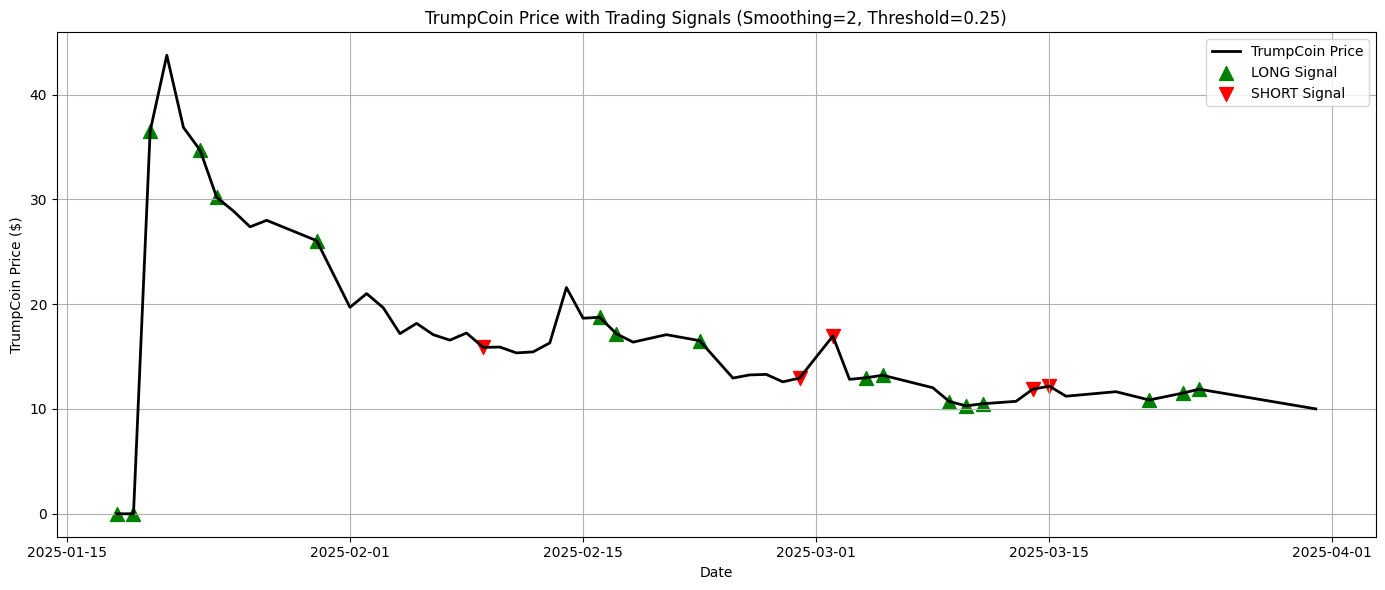

In [479]:
# === CONFIGURATION ===

SMOOTHING_WINDOW = 2
SENTIMENT_THRESHOLD = 0.35

# === LOAD DATA ===

# Load sentiment and prices
daily_sentiment = pd.read_csv("daily_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# === APPLY SMOOTHING AND SIGNAL ===

df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > SENTIMENT_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -SENTIMENT_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# === PLOT TRADING SIGNALS ON TRUMPCOIN PRICE ===

plt.figure(figsize=(14,6))

# Plot TrumpCoin price
plt.plot(df['date'], df['close'], label='TrumpCoin Price', color='black', linewidth=2)

# Highlight trade signals
long_dates = df[df['signal'] == 'LONG']['date']
short_dates = df[df['signal'] == 'SHORT']['date']
hold_dates = df[df['signal'] == 'HOLD']['date']

plt.scatter(long_dates, df[df['signal'] == 'LONG']['close'],
            marker='^', color='green', label='LONG Signal', s=100)

plt.scatter(short_dates, df[df['signal'] == 'SHORT']['close'],
            marker='v', color='red', label='SHORT Signal', s=100)

# Optional: if you want to also show HOLDs
# plt.scatter(hold_dates, df[df['signal'] == 'HOLD']['close'],
#             marker='o', color='gray', label='HOLD Signal', s=50)

plt.xlabel('Date')
plt.ylabel('TrumpCoin Price ($)')
plt.title('TrumpCoin Price with Trading Signals (Smoothing=2, Threshold=0.25)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

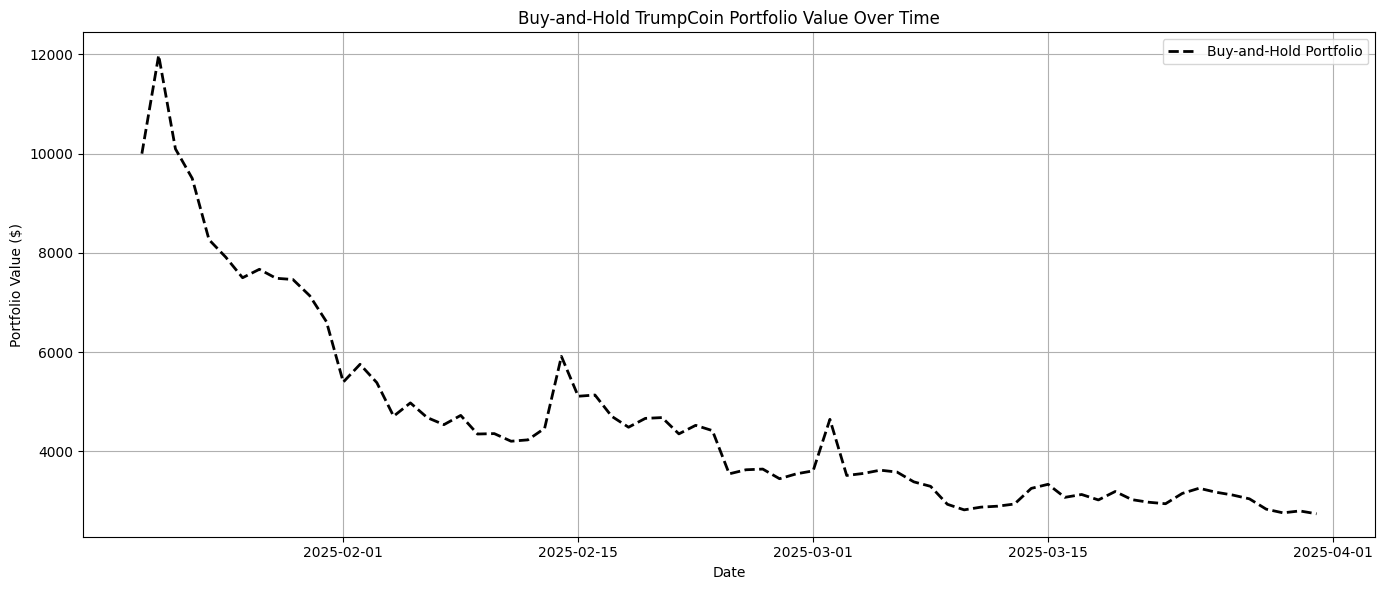

In [480]:
STARTING_PORTFOLIO = 10000

# === LOAD PRICE DATA ===

prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# === CALCULATE BUY-AND-HOLD PORTFOLIO VALUE ===

# Assume you buy on the first non-zero close price
valid_prices = prices[prices['close'] > 0].reset_index(drop=True)

initial_price = valid_prices['close'].iloc[0]
buy_and_hold_values = STARTING_PORTFOLIO * (valid_prices['close'] / initial_price)

# === PLOT ===

plt.figure(figsize=(14,6))

plt.plot(valid_prices['date'], buy_and_hold_values, label='Buy-and-Hold Portfolio', color='black', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Buy-and-Hold TrumpCoin Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

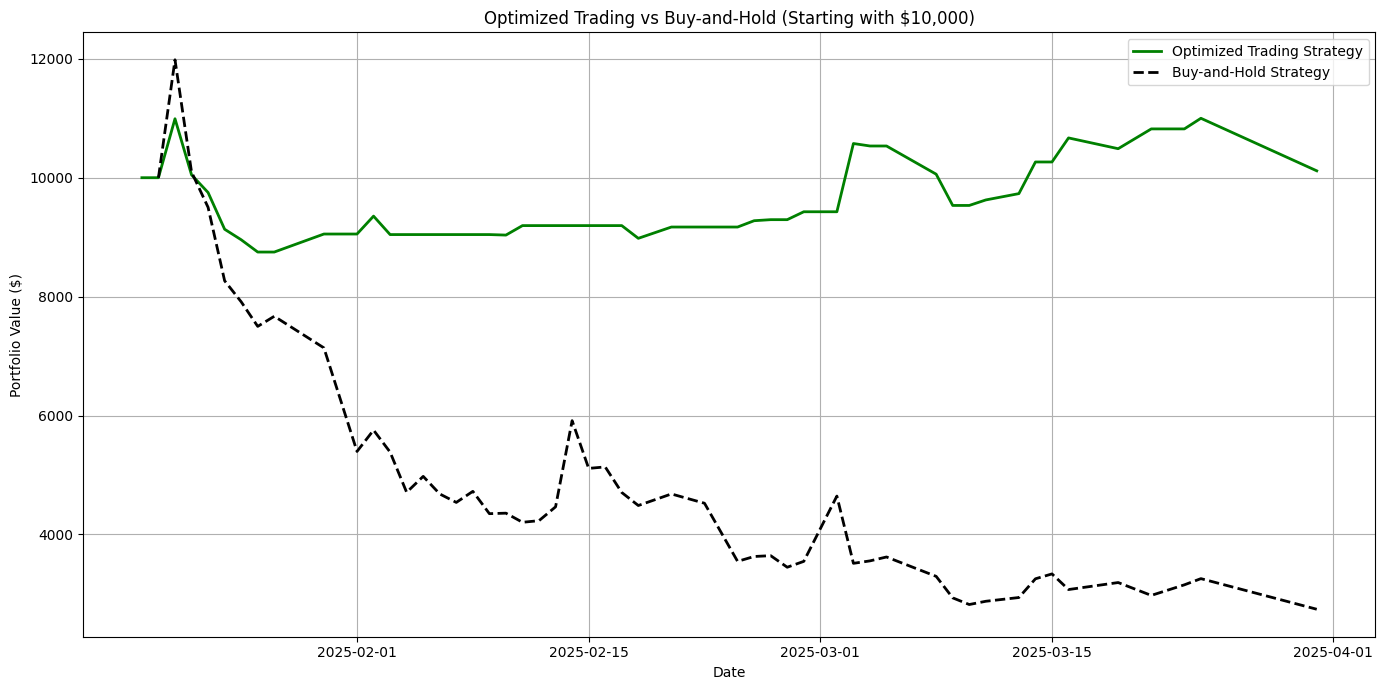

In [481]:
# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000
TRADE_PERCENT = 0.5
OPTIMIZED_THRESHOLD = 0.25
OPTIMIZED_SMOOTHING_WINDOW = 2

# === LOAD DATA ===

# Load sentiment and prices
sentiment = pd.read_csv("daily_sentiment.csv")
sentiment['date'] = pd.to_datetime(sentiment['date'])

prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# === CALCULATE BUY-AND-HOLD PORTFOLIO ===

valid_prices = df[df['close'] > 0].reset_index(drop=True)
initial_price = valid_prices['close'].iloc[0]
buy_and_hold_values = STARTING_PORTFOLIO * (valid_prices['close'] / initial_price)

# === SIMULATE OPTIMIZED TRADING STRATEGY ===

df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=OPTIMIZED_SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > OPTIMIZED_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -OPTIMIZED_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

portfolio = STARTING_PORTFOLIO
position = None
entry_price = None
trade_size = 0
optimized_portfolio_values = []

for i in range(1, len(df)):
    today = df.loc[i]
    yesterday = df.loc[i-1]

    today_price = today['close']
    if today_price == 0 or pd.isna(today_price):
        optimized_portfolio_values.append(portfolio)
        continue

    signal = yesterday['signal']

    if signal == 'LONG':
        if position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'LONG':
            trade_size = portfolio * TRADE_PERCENT
            position = 'LONG'
            entry_price = today_price

    elif signal == 'SHORT':
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'SHORT':
            trade_size = portfolio * TRADE_PERCENT
            position = 'SHORT'
            entry_price = today_price

    else:  # HOLD
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
        elif position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
        position = None
        entry_price = None

    if position == 'LONG' and entry_price is not None:
        unrealized = trade_size * (today_price / entry_price - 1)
    elif position == 'SHORT' and entry_price is not None:
        unrealized = trade_size * (1 - today_price / entry_price)
    else:
        unrealized = 0

    optimized_portfolio_values.append(portfolio + unrealized)

# === ALIGN DATES FOR PLOTTING ===

# optimized_portfolio_values starts from day 1 because of lag (uses yesterday's signal)
optimized_dates = df['date'][1:]

# buy_and_hold_values starts from date 0
buy_and_hold_dates = valid_prices['date']

# === PLOT ===

plt.figure(figsize=(14,7))

plt.plot(optimized_dates, optimized_portfolio_values, label='Optimized Trading Strategy', color='green', linewidth=2)
plt.plot(buy_and_hold_dates, buy_and_hold_values, label='Buy-and-Hold Strategy', color='black', linestyle='--', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Optimized Trading vs Buy-and-Hold (Starting with $10,000)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

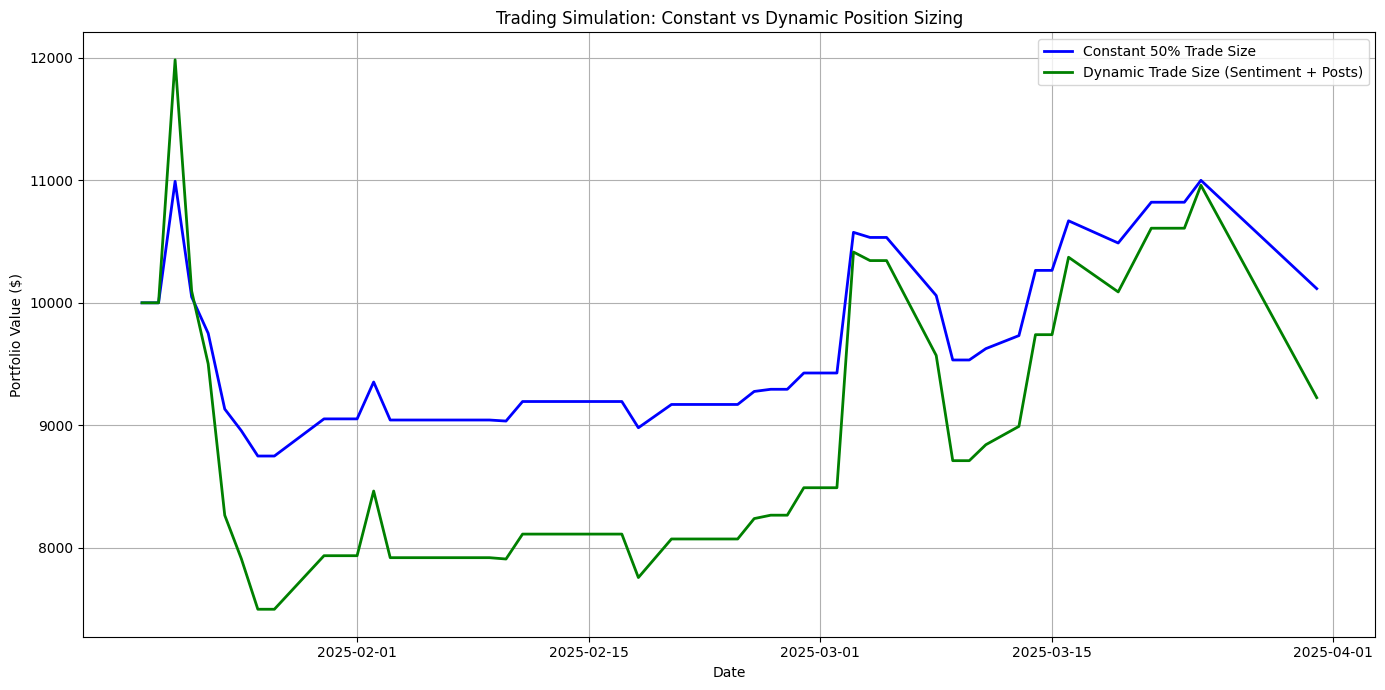

In [482]:
# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000

# Trading parameters
BASE_TRADE_PERCENT = 0.5
SENTIMENT_WEIGHT = 1.0
POSTS_WEIGHT = 0.5

# Signal generation
SMOOTHING_WINDOW = 2
THRESHOLD = 0.25

# === LOAD DATA ===

# Load sentiment with number of posts
daily_sentiment = pd.read_csv("daily_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Load TrumpCoin prices
prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# Preprocessing
average_num_posts = df['num_posts'].mean()
df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# === SIMULATOR FUNCTION ===

def simulate_trading(use_dynamic_sizing):
    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0
    portfolio_values = []

    for i in range(1, len(df)):
        today = df.loc[i]
        yesterday = df.loc[i-1]

        today_price = today['close']
        if today_price == 0 or pd.isna(today_price):
            portfolio_values.append(portfolio)
            continue

        signal = yesterday['signal']

        # Position sizing
        if use_dynamic_sizing:
            sentiment_strength = abs(yesterday['smoothed_sentiment'])
            post_strength = yesterday['num_posts'] / average_num_posts
            dynamic_trade_percent = BASE_TRADE_PERCENT * (1 + SENTIMENT_WEIGHT * sentiment_strength) * (1 + POSTS_WEIGHT * post_strength)
            dynamic_trade_percent = min(max(dynamic_trade_percent, 0.0), 1.0)
            effective_trade_percent = dynamic_trade_percent
        else:
            effective_trade_percent = BASE_TRADE_PERCENT

        # Trading logic
        if signal == 'LONG':
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * effective_trade_percent
                position = 'LONG'
                entry_price = today_price

        elif signal == 'SHORT':
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * effective_trade_percent
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        # Update portfolio value
        if position == 'LONG' and entry_price is not None:
            unrealized = trade_size * (today_price / entry_price - 1)
        elif position == 'SHORT' and entry_price is not None:
            unrealized = trade_size * (1 - today_price / entry_price)
        else:
            unrealized = 0

        total_value = portfolio + unrealized
        portfolio_values.append(total_value)

    return portfolio_values

# === RUN BOTH SIMULATIONS ===

dynamic_values = simulate_trading(use_dynamic_sizing=True)
constant_values = simulate_trading(use_dynamic_sizing=False)

# === PLOT COMPARISON ===

plt.figure(figsize=(14,7))

plt.plot(df['date'][1:], constant_values, label='Constant 50% Trade Size', color='blue', linewidth=2)
plt.plot(df['date'][1:], dynamic_values, label='Dynamic Trade Size (Sentiment + Posts)', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Trading Simulation: Constant vs Dynamic Position Sizing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


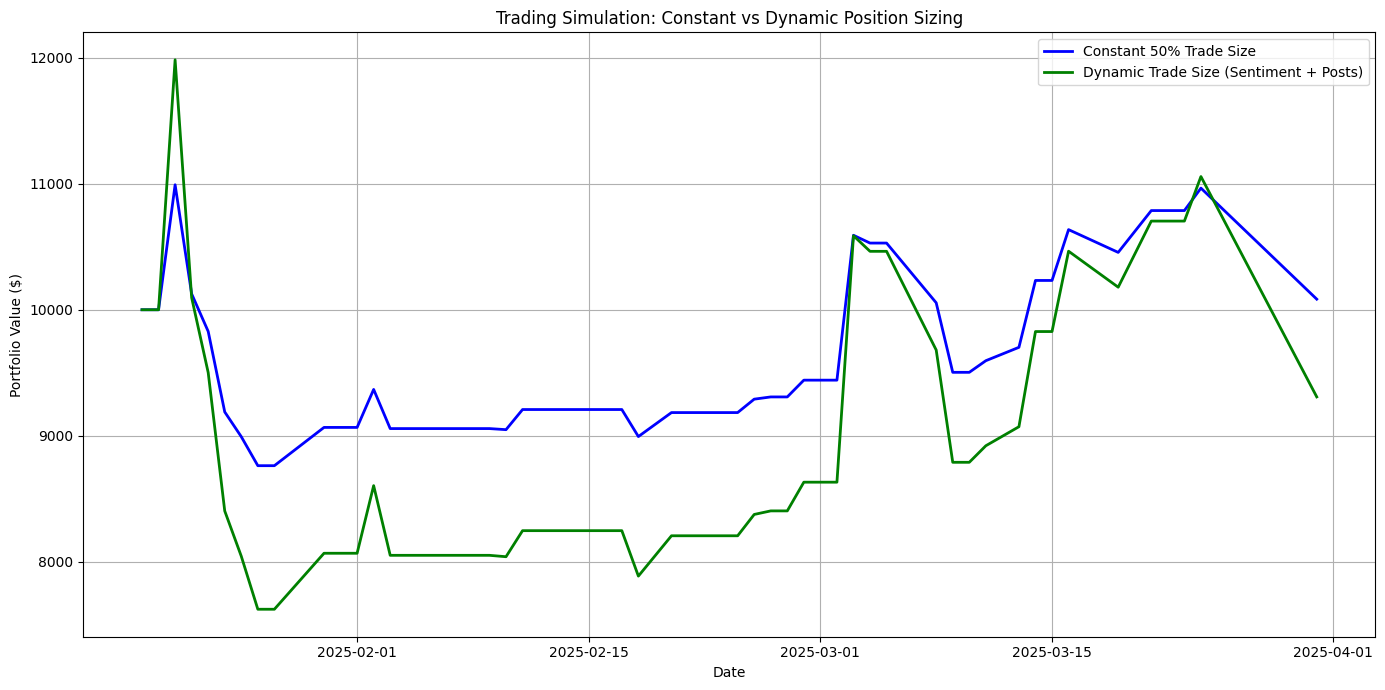

In [483]:
# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000

# Trading parameters
BASE_TRADE_PERCENT = 0.5
SENTIMENT_WEIGHT = 1.0
POSTS_WEIGHT = 0.5

# Signal generation
SMOOTHING_WINDOW = 2
THRESHOLD = 0.25

# Stop Loss / Take Profit parameters
USE_STOPLOSS_TAKEPROFIT = True
STOP_LOSS_PERCENT = 0.05    # 5% loss triggers exit
TAKE_PROFIT_PERCENT = 0.10  # 10% gain triggers exit

# === LOAD DATA ===

# Load sentiment with number of posts
daily_sentiment = pd.read_csv("daily_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Load TrumpCoin prices
prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# Preprocessing
average_num_posts = df['num_posts'].mean()
df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# === SIMULATOR FUNCTION ===

def simulate_trading(use_dynamic_sizing):
    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0
    portfolio_values = []

    for i in range(1, len(df)):
        today = df.loc[i]
        yesterday = df.loc[i-1]

        today_price = today['close']
        if today_price == 0 or pd.isna(today_price):
            portfolio_values.append(portfolio)
            continue

        signal = yesterday['signal']

        # Position sizing
        if use_dynamic_sizing:
            sentiment_strength = abs(yesterday['smoothed_sentiment'])
            post_strength = yesterday['num_posts'] / average_num_posts
            dynamic_trade_percent = BASE_TRADE_PERCENT * (1 + SENTIMENT_WEIGHT * sentiment_strength) * (1 + POSTS_WEIGHT * post_strength)
            dynamic_trade_percent = min(max(dynamic_trade_percent, 0.0), 1.0)
            effective_trade_percent = dynamic_trade_percent
        else:
            effective_trade_percent = BASE_TRADE_PERCENT

        # === Check Stop Loss / Take Profit first ===
        if USE_STOPLOSS_TAKEPROFIT and position is not None and entry_price is not None:
            if position == 'LONG':
                if today_price <= entry_price * (1 - STOP_LOSS_PERCENT):
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None
                elif today_price >= entry_price * (1 + TAKE_PROFIT_PERCENT):
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None

            elif position == 'SHORT':
                if today_price >= entry_price * (1 + STOP_LOSS_PERCENT):
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None
                elif today_price <= entry_price * (1 - TAKE_PROFIT_PERCENT):
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None

        # === Trading logic based on signals ===
        if signal == 'LONG':
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * effective_trade_percent
                position = 'LONG'
                entry_price = today_price

        elif signal == 'SHORT':
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * effective_trade_percent
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        # Update portfolio value
        if position == 'LONG' and entry_price is not None:
            unrealized = trade_size * (today_price / entry_price - 1)
        elif position == 'SHORT' and entry_price is not None:
            unrealized = trade_size * (1 - today_price / entry_price)
        else:
            unrealized = 0

        total_value = portfolio + unrealized
        portfolio_values.append(total_value)

    return portfolio_values

# === RUN BOTH SIMULATIONS ===

dynamic_values = simulate_trading(use_dynamic_sizing=True)
constant_values = simulate_trading(use_dynamic_sizing=False)

# === PLOT COMPARISON ===

plt.figure(figsize=(14,7))

plt.plot(df['date'][1:], constant_values, label='Constant 50% Trade Size', color='blue', linewidth=2)
plt.plot(df['date'][1:], dynamic_values, label='Dynamic Trade Size (Sentiment + Posts)', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Trading Simulation: Constant vs Dynamic Position Sizing')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


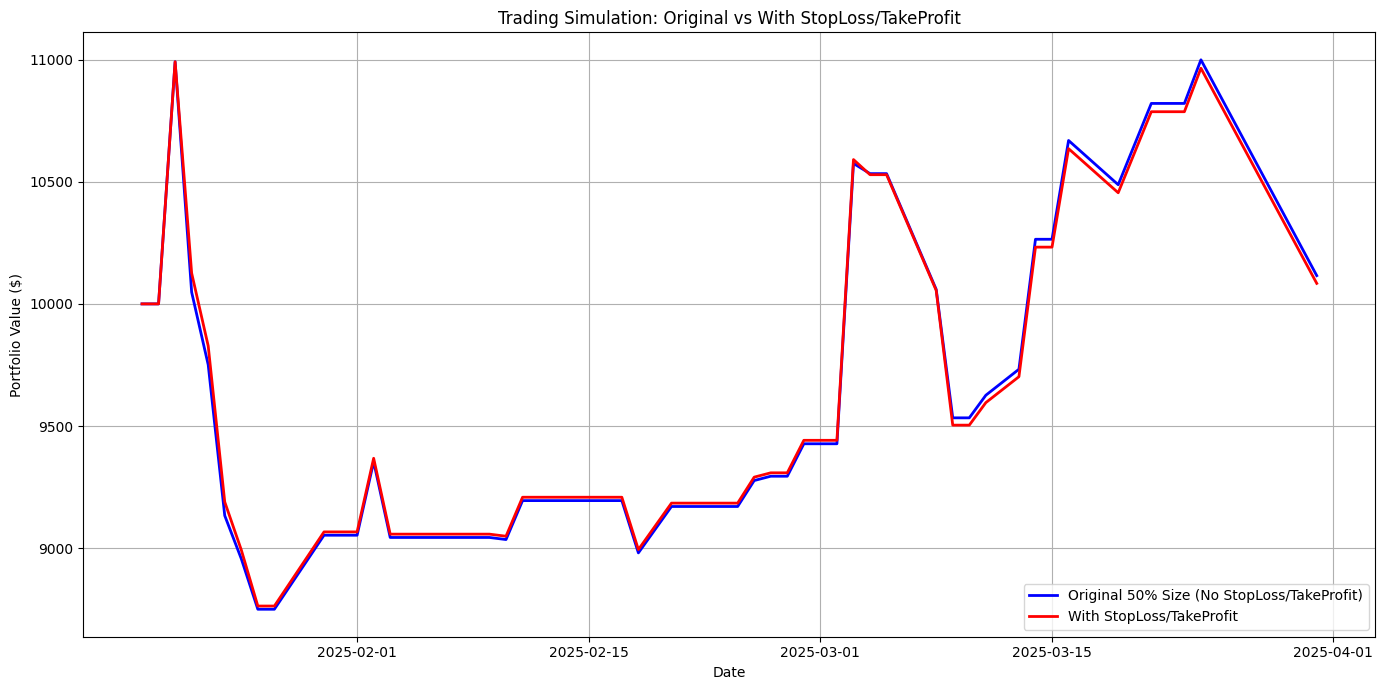

In [484]:
# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000

# Trading parameters
BASE_TRADE_PERCENT = 0.5

# Signal generation
SMOOTHING_WINDOW = 2
THRESHOLD = 0.25

# Stop Loss / Take Profit parameters
STOP_LOSS_PERCENT = 0.05    # 5% stop loss
TAKE_PROFIT_PERCENT = 0.10  # 10% take profit

# === LOAD DATA ===

# Load sentiment with number of posts
daily_sentiment = pd.read_csv("daily_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Load TrumpCoin prices
prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# Preprocessing
df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# === SIMULATOR FUNCTION ===

def simulate_trading(use_stoploss_takeprofit):
    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0
    portfolio_values = []

    for i in range(1, len(df)):
        today = df.loc[i]
        yesterday = df.loc[i-1]

        today_price = today['close']
        if today_price == 0 or pd.isna(today_price):
            portfolio_values.append(portfolio)
            continue

        signal = yesterday['signal']

        # === Check Stop Loss / Take Profit ===
        if use_stoploss_takeprofit and position is not None and entry_price is not None:
            if position == 'LONG':
                if today_price <= entry_price * (1 - STOP_LOSS_PERCENT):
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None
                elif today_price >= entry_price * (1 + TAKE_PROFIT_PERCENT):
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None

            elif position == 'SHORT':
                if today_price >= entry_price * (1 + STOP_LOSS_PERCENT):
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None
                elif today_price <= entry_price * (1 - TAKE_PROFIT_PERCENT):
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None

        # === Trading logic based on signals ===
        if signal == 'LONG':
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * BASE_TRADE_PERCENT
                position = 'LONG'
                entry_price = today_price

        elif signal == 'SHORT':
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * BASE_TRADE_PERCENT
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        # Update portfolio value
        if position == 'LONG' and entry_price is not None:
            unrealized = trade_size * (today_price / entry_price - 1)
        elif position == 'SHORT' and entry_price is not None:
            unrealized = trade_size * (1 - today_price / entry_price)
        else:
            unrealized = 0

        total_value = portfolio + unrealized
        portfolio_values.append(total_value)

    return portfolio_values

# === RUN SIMULATIONS ===

# Original constant 50% strategy (NO stoploss/takeprofit)
original_values = simulate_trading(use_stoploss_takeprofit=False)

# 50% strategy WITH stoploss/takeprofit
stoploss_tp_values = simulate_trading(use_stoploss_takeprofit=True)

# === PLOT COMPARISON ===

plt.figure(figsize=(14,7))

plt.plot(df['date'][1:], original_values, label='Original 50% Size (No StopLoss/TakeProfit)', color='blue', linewidth=2)
plt.plot(df['date'][1:], stoploss_tp_values, label='With StopLoss/TakeProfit', color='red', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Trading Simulation: Original vs With StopLoss/TakeProfit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


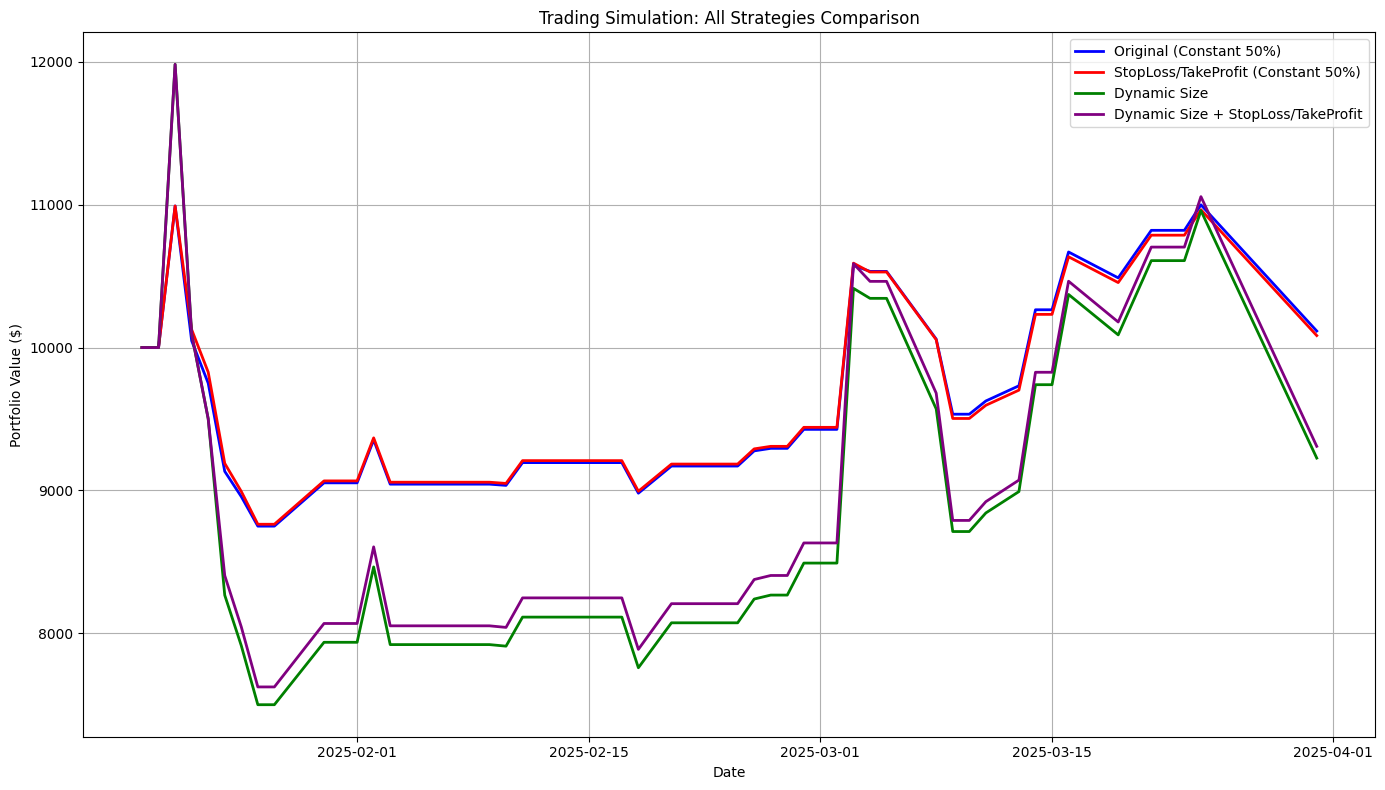

In [485]:
# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000

# Trading parameters
BASE_TRADE_PERCENT = 0.5
SENTIMENT_WEIGHT = 1.0
POSTS_WEIGHT = 0.5

# Signal generation
SMOOTHING_WINDOW = 2
THRESHOLD = 0.25

# Stop Loss / Take Profit parameters
STOP_LOSS_PERCENT = 0.05    # 5% stop loss
TAKE_PROFIT_PERCENT = 0.10  # 10% take profit

# === LOAD DATA ===

# Load sentiment with number of posts
daily_sentiment = pd.read_csv("daily_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Load TrumpCoin prices
prices = pd.read_csv("trumpcoin_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# Preprocessing
average_num_posts = df['num_posts'].mean()
df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# === SIMULATOR FUNCTION ===

def simulate_trading(use_dynamic_sizing=False, use_stoploss_takeprofit=False):
    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0
    portfolio_values = []

    for i in range(1, len(df)):
        today = df.loc[i]
        yesterday = df.loc[i-1]

        today_price = today['close']
        if today_price == 0 or pd.isna(today_price):
            portfolio_values.append(portfolio)
            continue

        signal = yesterday['signal']

        # Position sizing
        if use_dynamic_sizing:
            sentiment_strength = abs(yesterday['smoothed_sentiment'])
            post_strength = yesterday['num_posts'] / average_num_posts
            dynamic_trade_percent = BASE_TRADE_PERCENT * (1 + SENTIMENT_WEIGHT * sentiment_strength) * (1 + POSTS_WEIGHT * post_strength)
            dynamic_trade_percent = min(max(dynamic_trade_percent, 0.0), 1.0)
            effective_trade_percent = dynamic_trade_percent
        else:
            effective_trade_percent = BASE_TRADE_PERCENT

        # === Check Stop Loss / Take Profit first ===
        if use_stoploss_takeprofit and position is not None and entry_price is not None:
            if position == 'LONG':
                if today_price <= entry_price * (1 - STOP_LOSS_PERCENT):
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None
                elif today_price >= entry_price * (1 + TAKE_PROFIT_PERCENT):
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None

            elif position == 'SHORT':
                if today_price >= entry_price * (1 + STOP_LOSS_PERCENT):
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None
                elif today_price <= entry_price * (1 - TAKE_PROFIT_PERCENT):
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None

        # === Trading logic based on signals ===
        if signal == 'LONG':
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * effective_trade_percent
                position = 'LONG'
                entry_price = today_price

        elif signal == 'SHORT':
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * effective_trade_percent
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        # Update portfolio value
        if position == 'LONG' and entry_price is not None:
            unrealized = trade_size * (today_price / entry_price - 1)
        elif position == 'SHORT' and entry_price is not None:
            unrealized = trade_size * (1 - today_price / entry_price)
        else:
            unrealized = 0

        total_value = portfolio + unrealized
        portfolio_values.append(total_value)

    return portfolio_values

# === RUN ALL SIMULATIONS ===

original_values = simulate_trading(use_dynamic_sizing=False, use_stoploss_takeprofit=False)
stoploss_tp_values = simulate_trading(use_dynamic_sizing=False, use_stoploss_takeprofit=True)
dynamic_values = simulate_trading(use_dynamic_sizing=True, use_stoploss_takeprofit=False)
dynamic_stoploss_tp_values = simulate_trading(use_dynamic_sizing=True, use_stoploss_takeprofit=True)

# === PLOT EVERYTHING ===

plt.figure(figsize=(14,8))

plt.plot(df['date'][1:], original_values, label='Original (Constant 50%)', color='blue', linewidth=2)
plt.plot(df['date'][1:], stoploss_tp_values, label='StopLoss/TakeProfit (Constant 50%)', color='red', linewidth=2)
plt.plot(df['date'][1:], dynamic_values, label='Dynamic Size', color='green', linewidth=2)
plt.plot(df['date'][1:], dynamic_stoploss_tp_values, label='Dynamic Size + StopLoss/TakeProfit', color='purple', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Trading Simulation: All Strategies Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


***DOGE TIME***

In [ ]:
# === CONFIGURATION ===

# Reddit Authentication
REDDIT_CLIENT_ID = "suCjVen6MTRiU9E88cqRAg"
REDDIT_CLIENT_SECRET = "UiP81w6C1qyenfZzJ0asiegtJlQtZA"
REDDIT_USER_AGENT = "ECE473 Final Project"

reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
)

# Subreddits to scrape (more DOGE-related)
SUBREDDITS = ["CryptoCurrency", "dogecoin", "CryptoMarkets", "SatoshiStreetBets", "CryptoMoonShots"]

# Regex pattern to match Dogecoin mentions
DOGE_REGEX = re.compile(r"(?i)\b(doge\s*coin|dogecoin|\$doge)\b")

# Output CSV
OUTPUT_FILE = "reddit_dogecoin_filtered.csv"

# Target Time Window
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2025, 4, 19)

# Sleep time between API calls
SLEEP_TIME = 0.5  # seconds

# === HELPER FUNCTIONS ===

def match_dogecoin(text):
    """Check if text matches Dogecoin regex."""
    if text:
        return bool(DOGE_REGEX.search(text))
    return False

def utc_to_datetime(utc_timestamp):
    """Convert UTC timestamp to datetime object."""
    return datetime.utcfromtimestamp(utc_timestamp)

def is_within_date_range(utc_timestamp):
    """Check if the post/comment is within the target date window."""
    post_time = utc_to_datetime(utc_timestamp)
    return START_DATE <= post_time <= END_DATE

def extract_post_data(post):
    """Extract fields from a Reddit post."""
    return {
        "source": "post",
        "parent_id": post.id,
        "subreddit": post.subreddit.display_name,
        "author": str(post.author),
        "score": post.score,
        "created_utc": utc_to_datetime(post.created_utc),
        "text": (post.title or "") + " " + (post.selftext or ""),
        "permalink": f"https://reddit.com{post.permalink}"
    }

def extract_comment_data(comment, parent_id):
    """Extract fields from a Reddit comment."""
    return {
        "source": "comment",
        "parent_id": parent_id,
        "subreddit": comment.subreddit.display_name,
        "author": str(comment.author),
        "score": comment.score,
        "created_utc": utc_to_datetime(comment.created_utc),
        "text": comment.body,
        "permalink": f"https://reddit.com{comment.permalink}" if hasattr(comment, "permalink") else None
    }

# === MAIN SCRAPER ===

def main():
    all_data = []

    for subreddit_name in SUBREDDITS:
        print(f"Searching subreddit: {subreddit_name}")
        subreddit = reddit.subreddit(subreddit_name)

        # Start fetching newest posts
        for post in subreddit.search("dogecoin OR \"doge coin\" OR $doge", sort="new", limit=None):
            post_time = utc_to_datetime(post.created_utc)

            # Stop if we went before the START_DATE
            if post_time < START_DATE:
                print(f"Reached post before start date {START_DATE.date()}. Stopping for subreddit {subreddit_name}.")
                break

            if not is_within_date_range(post.created_utc):
                continue

            post_text = (post.title or "") + " " + (post.selftext or "")
            if match_dogecoin(post_text):
                all_data.append(extract_post_data(post))

                try:
                    post.comments.replace_more(limit=0)
                    for comment in post.comments.list():
                        if is_within_date_range(comment.created_utc) and match_dogecoin(comment.body):
                            all_data.append(extract_comment_data(comment, parent_id=post.id))
                except Exception as e:
                    print(f"Error fetching comments: {e}")

            time.sleep(SLEEP_TIME)

    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Saved {len(df)} records to {OUTPUT_FILE}")

# === ENTRY POINT ===

if __name__ == "__main__":
    main()


Searching subreddit: CryptoCurrency
Searching subreddit: dogecoin
Searching subreddit: CryptoMarkets
Searching subreddit: SatoshiStreetBets
Reached post before start date 2024-01-01. Stopping for subreddit SatoshiStreetBets.
Searching subreddit: CryptoMoonShots
Saved 635 records to reddit_dogecoin_filtered.csv


In [494]:
print(df)

         date  avg_sentiment  num_posts   close  smoothed_sentiment signal
0  2025-01-18       0.995600          2  0.3964            0.995600   LONG
1  2025-01-19       0.996000          1  0.3584            0.995800   LONG
2  2025-01-20       0.529627         11  0.3546            0.840409   LONG
3  2025-01-21       0.146350         14  0.3718            0.666894   LONG
4  2025-01-22       0.383367          3  0.3629            0.610189   LONG
5  2025-01-23       0.457520          5  0.3520            0.502573   LONG
6  2025-01-24       0.722660          5  0.3509            0.447905   LONG
7  2025-01-25      -0.607200          1  0.3535            0.220539   LONG
8  2025-01-26      -0.040800          2  0.3360            0.183109   LONG
9  2025-01-27       0.224878          9  0.3340            0.151412   LONG
10 2025-01-30       0.972900          2  0.3315            0.254488   LONG
11 2025-02-01      -0.318200          1  0.3079            0.046316   HOLD
12 2025-02-02       0.432

In [488]:
# === INITIAL SETUP ===

# Load your scraped data
INPUT_FILE = "reddit_dogecoin_filtered.csv"
OUTPUT_FILE = "reddit_dogecoin_sentiment.csv"

# Download VADER Lexicon (only need to do this once)
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Load the CSV
df = pd.read_csv(INPUT_FILE)

# === SENTIMENT ANALYSIS ===

# Function to compute VADER sentiment score
def get_sentiment(text):
    if isinstance(text, str):
        return sia.polarity_scores(text)['compound']
    else:
        return 0  # If text is NaN or not a string, return neutral

# Apply sentiment analysis to each row
df['sentiment_score'] = df['text'].apply(get_sentiment)

# Save the new DataFrame
df.to_csv(OUTPUT_FILE, index=False)

print(f"Saved sentiment-scored data to {OUTPUT_FILE}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ateye\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Saved sentiment-scored data to reddit_dogecoin_sentiment.csv


In [489]:
import pandas as pd

# Load your sentiment-scored Reddit data
df = pd.read_csv("reddit_dogecoin_sentiment.csv")

# Ensure created_utc is a datetime object
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Create a new column: half-day block
def assign_half_day(timestamp):
    if timestamp.hour < 12:
        return timestamp.date().strftime("%Y-%m-%d") + "_AM"
    else:
        return timestamp.date().strftime("%Y-%m-%d") + "_PM"

df['half_day'] = df['created_utc'].apply(assign_half_day)

# Group by half-day
half_day_sentiment = df.groupby('half_day').agg(
    avg_sentiment=('sentiment_score', 'mean'),
    num_posts=('sentiment_score', 'count')
).reset_index()

# Save to CSV (optional)
half_day_sentiment.to_csv("half_day_sentiment.csv", index=False)

# Preview
print(half_day_sentiment.head(255))

          half_day  avg_sentiment  num_posts
0    2024-02-01_PM       0.086750          2
1    2024-02-04_AM       0.886000          1
2    2024-02-05_PM       0.608300          1
3    2024-02-29_AM       0.361200          1
4    2024-03-04_AM       0.715600          1
..             ...            ...        ...
240  2025-04-15_PM       0.384540          5
241  2025-04-16_AM      -0.250080          5
242  2025-04-17_PM       0.222260          5
243  2025-04-18_AM       0.072933          3
244  2025-04-18_PM       0.137260          5

[245 rows x 3 columns]


In [507]:
# Load your daily sentiment data
daily_sentiment = pd.read_csv("half_day_sentiment.csv")

# === TRADING RULES ===

def generate_signal(avg_sentiment):
    if avg_sentiment > 0.05:
        return "BUY"
    elif avg_sentiment < -0.05:
        return "SELL"
    else:
        return "HOLD"

# Apply trading rule
daily_sentiment['signal'] = daily_sentiment['avg_sentiment'].apply(generate_signal)

# Save to CSV (optional)
daily_sentiment.to_csv("daily_sentiment_signals.csv", index=False)

# Preview
print(daily_sentiment.head(250))

          half_day  avg_sentiment  num_posts signal
0    2024-02-01_PM       0.086750          2    BUY
1    2024-02-04_AM       0.886000          1    BUY
2    2024-02-05_PM       0.608300          1    BUY
3    2024-02-29_AM       0.361200          1    BUY
4    2024-03-04_AM       0.715600          1    BUY
..             ...            ...        ...    ...
240  2025-04-15_PM       0.384540          5    BUY
241  2025-04-16_AM      -0.250080          5   SELL
242  2025-04-17_PM       0.222260          5    BUY
243  2025-04-18_AM       0.072933          3    BUY
244  2025-04-18_PM       0.137260          5    BUY

[245 rows x 4 columns]


In [ ]:
# === CONFIGURATION ===

API_KEY = "5a69a69b336064e8f6c950f66d17ef5e08c727162f1c06e70e17722f8af024ef"  # <-- put your key here

# CryptoCompare endpoint for daily data
url = "https://min-api.cryptocompare.com/data/v2/histoday"

# TrumpCoin symbol
FSYM = "DOGE"
# Quote currency
TSYM = "USDT"

# Time window
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2025, 4, 19)

# Calculate how many days to request
days_diff = (END_DATE - START_DATE).days

# === API Request ===

params = {
    "fsym": FSYM,
    "tsym": TSYM,
    "limit": days_diff,   # number of data points - 1
    "toTs": int(END_DATE.timestamp()),
    "api_key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

# Check if request succeeded
if data['Response'] != 'Success':
    print("Error fetching data:", data)
    raise Exception("Failed to fetch price data.")

# Extract price data
price_data = data['Data']['Data']

# Convert to DataFrame
df_prices = pd.DataFrame(price_data)

# Convert timestamp to date
df_prices['date'] = pd.to_datetime(df_prices['time'], unit='s')
df_prices = df_prices[['date', 'close']]

# Save to CSV
df_prices.to_csv("doge_prices.csv", index=False)

print(df_prices.head(500))
print(f"Saved {len(df_prices)} days of DogeCoin prices to doge_prices.csv")

          date    close
0   2024-01-01  0.09201
1   2024-01-02  0.09109
2   2024-01-03  0.08200
3   2024-01-04  0.08400
4   2024-01-05  0.08267
..         ...      ...
470 2025-04-15  0.15360
471 2025-04-16  0.15470
472 2025-04-17  0.15590
473 2025-04-18  0.15760
474 2025-04-19  0.15730

[475 rows x 2 columns]
Saved 475 days of DogeCoin prices to doge_prices.csv


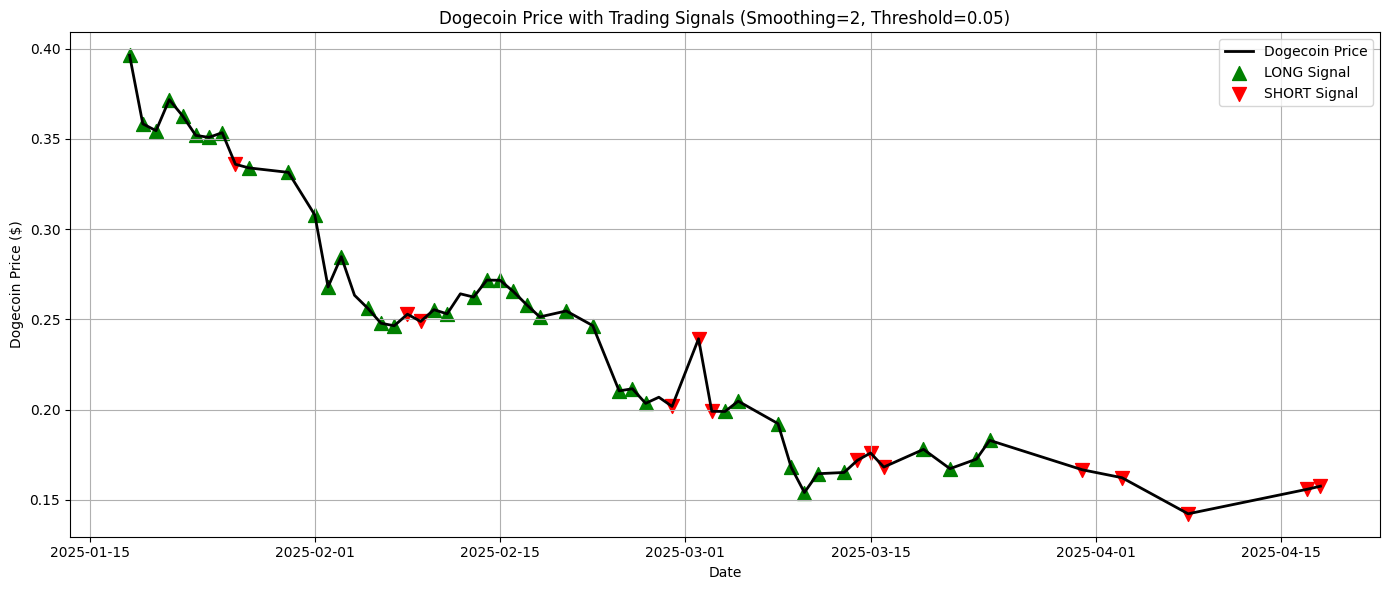

In [491]:
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURATION ===

SMOOTHING_WINDOW = 2
SENTIMENT_THRESHOLD = 0.05

# === LOAD DATA ===

# Load Dogecoin sentiment and prices
daily_sentiment = pd.read_csv("daily_sentiment.csv")  # <-- Your Dogecoin daily sentiment file
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

prices = pd.read_csv("doge_prices.csv")  # <-- Your Dogecoin daily prices
prices['date'] = pd.to_datetime(prices['date'])

# Merge
df = pd.merge(daily_sentiment, prices, on='date', how='inner')
df = df.sort_values('date').reset_index(drop=True)

# === APPLY SMOOTHING AND GENERATE SIGNALS ===

df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > SENTIMENT_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -SENTIMENT_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# === PLOT DOGECOIN PRICE WITH SIGNALS ===

plt.figure(figsize=(14,6))

# Plot Dogecoin price
plt.plot(df['date'], df['close'], label='Dogecoin Price', color='black', linewidth=2)

# Highlight trade signals
long_dates = df[df['signal'] == 'LONG']['date']
short_dates = df[df['signal'] == 'SHORT']['date']

plt.scatter(long_dates, df[df['signal'] == 'LONG']['close'],
            marker='^', color='green', label='LONG Signal', s=100)

plt.scatter(short_dates, df[df['signal'] == 'SHORT']['close'],
            marker='v', color='red', label='SHORT Signal', s=100)

# Optional: also show HOLD signals
# hold_dates = df[df['signal'] == 'HOLD']['date']
# plt.scatter(hold_dates, df[df['signal'] == 'HOLD']['close'],
#             marker='o', color='gray', label='HOLD Signal', s=50)

plt.xlabel('Date')
plt.ylabel('Dogecoin Price ($)')
plt.title('Dogecoin Price with Trading Signals (Smoothing=2, Threshold=0.05)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

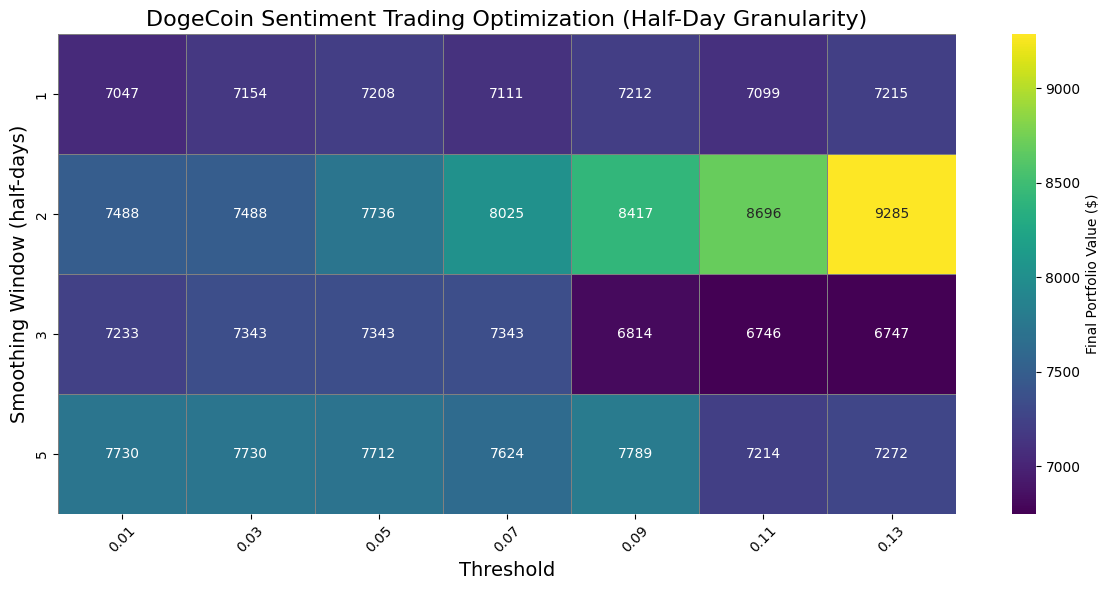

In [492]:
# === OPTIMIZATION ===
STARTING_PORTFOLIO = 10000
TRADE_PERCENT = 0.5

smoothing_windows = [1, 2, 3, 5]
thresholds = np.arange(0.01, 0.15, 0.02)

results = []

for window in smoothing_windows:
    for threshold in thresholds:
        portfolio = STARTING_PORTFOLIO
        position = None
        entry_price = None
        trade_size = 0

        df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=window, min_periods=1).mean()

        def generate_signal(smoothed_sentiment):
            if smoothed_sentiment > threshold:
                return 'LONG'
            elif smoothed_sentiment < -threshold:
                return 'SHORT'
            else:
                return 'HOLD'

        df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

        for i in range(1, len(df)):
            today = df.loc[i]
            yesterday = df.loc[i-1]

            today_price = today['close']
            if today_price == 0 or pd.isna(today_price):
                continue

            signal = yesterday['signal']

            if signal == 'LONG':
                if position == 'SHORT' and entry_price is not None:
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None
                if position != 'LONG':
                    trade_size = portfolio * TRADE_PERCENT
                    position = 'LONG'
                    entry_price = today_price

            elif signal == 'SHORT':
                if position == 'LONG' and entry_price is not None:
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None
                if position != 'SHORT':
                    trade_size = portfolio * TRADE_PERCENT
                    position = 'SHORT'
                    entry_price = today_price

            else:  # HOLD
                if position == 'LONG' and entry_price is not None:
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                elif position == 'SHORT' and entry_price is not None:
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                position = None
                entry_price = None

        # Close any final open position
        if position == 'LONG' and entry_price is not None:
            final_price = df.loc[len(df)-1]['close']
            profit = trade_size * (final_price / entry_price - 1)
            portfolio += profit
        elif position == 'SHORT' and entry_price is not None:
            final_price = df.loc[len(df)-1]['close']
            profit = trade_size * (1 - final_price / entry_price)
            portfolio += profit

        results.append({
            'smoothing_window': window,
            'threshold': threshold,
            'final_portfolio': portfolio
        })

# === RESULTS ===
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot(index='smoothing_window', columns='threshold', values='final_portfolio')

# === PLOT ===
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, 
            annot=True, fmt=".0f", cmap="viridis",
            linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Final Portfolio Value ($)'})

plt.title('DogeCoin Sentiment Trading Optimization (Half-Day Granularity)', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Smoothing Window (half-days)', fontsize=14)

plt.xticks(ticks=np.arange(len(pivot_table.columns)) + 0.5, 
           labels=[f"{x:.2f}" for x in pivot_table.columns], rotation=45)
plt.yticks(ticks=np.arange(len(pivot_table.index)) + 0.5, 
           labels=pivot_table.index)

plt.tight_layout()
plt.show()


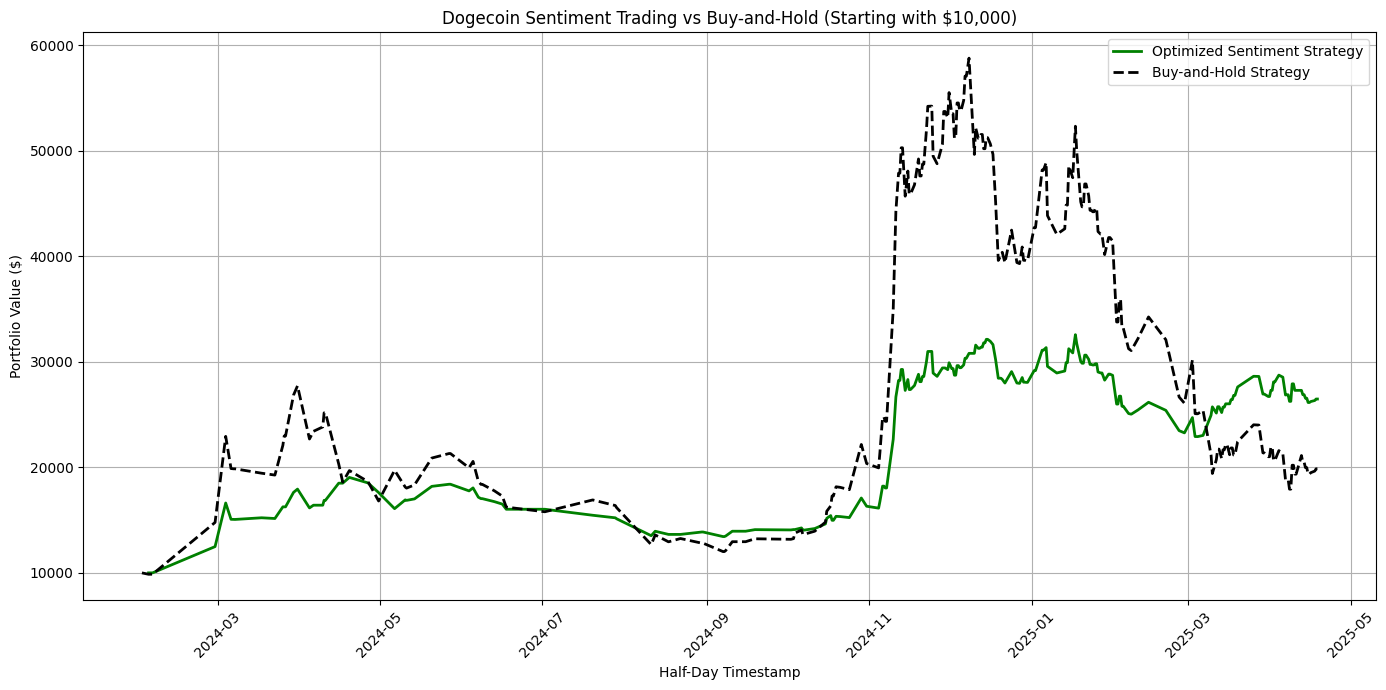

In [414]:
STARTING_PORTFOLIO = 10000
TRADE_PERCENT = 0.5

# Best parameters from optimization
OPTIMIZED_THRESHOLD = 0.05
OPTIMIZED_SMOOTHING_WINDOW = 2

# === LOAD DATA ===

# Load half-day sentiment
sentiment = pd.read_csv("half_day_sentiment.csv")

# Fix the half_day timestamp format
def fix_half_day(half_day_str):
    date_part, am_pm = half_day_str.split("_")
    if am_pm == "AM":
        return pd.to_datetime(date_part) + pd.Timedelta(hours=0)
    else:  # PM
        return pd.to_datetime(date_part) + pd.Timedelta(hours=12)

sentiment['half_day'] = sentiment['half_day'].apply(fix_half_day)

# Load Dogecoin DAILY prices
prices = pd.read_csv("doge_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Expand Dogecoin daily prices into half-days
# Each daily close will be duplicated for AM and PM

half_day_prices = []
for _, row in prices.iterrows():
    am_time = row['date'] + pd.Timedelta(hours=0)
    pm_time = row['date'] + pd.Timedelta(hours=12)
    price = row['close']
    half_day_prices.append({'half_day': am_time, 'close': price})
    half_day_prices.append({'half_day': pm_time, 'close': price})

half_day_prices_df = pd.DataFrame(half_day_prices)

# === MERGE ===

df = pd.merge(sentiment, half_day_prices_df, on='half_day', how='inner')
df = df.sort_values('half_day').reset_index(drop=True)

# === CALCULATE BUY-AND-HOLD PORTFOLIO ===

valid_prices = df[df['close'] > 0].reset_index(drop=True)
initial_price = valid_prices['close'].iloc[0]
buy_and_hold_values = STARTING_PORTFOLIO * (valid_prices['close'] / initial_price)

# === SIMULATE OPTIMIZED TRADING STRATEGY ===

df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=OPTIMIZED_SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > OPTIMIZED_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -OPTIMIZED_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

portfolio = STARTING_PORTFOLIO
position = None
entry_price = None
trade_size = 0
optimized_portfolio_values = []

for i in range(1, len(df)):
    today = df.loc[i]
    yesterday = df.loc[i-1]

    today_price = today['close']
    if today_price == 0 or pd.isna(today_price):
        optimized_portfolio_values.append(portfolio)
        continue

    signal = yesterday['signal']

    if signal == 'LONG':
        if position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'LONG':
            trade_size = portfolio * TRADE_PERCENT
            position = 'LONG'
            entry_price = today_price

    elif signal == 'SHORT':
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'SHORT':
            trade_size = portfolio * TRADE_PERCENT
            position = 'SHORT'
            entry_price = today_price

    else:  # HOLD
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
        elif position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
        position = None
        entry_price = None

    if position == 'LONG' and entry_price is not None:
        unrealized = trade_size * (today_price / entry_price - 1)
    elif position == 'SHORT' and entry_price is not None:
        unrealized = trade_size * (1 - today_price / entry_price)
    else:
        unrealized = 0

    optimized_portfolio_values.append(portfolio + unrealized)

# === ALIGN DATES FOR PLOTTING ===

optimized_dates = df['half_day'][1:]
buy_and_hold_dates = valid_prices['half_day']

# === PLOT ===

plt.figure(figsize=(14,7))

plt.plot(optimized_dates, optimized_portfolio_values, label='Optimized Sentiment Strategy', color='green', linewidth=2)
plt.plot(buy_and_hold_dates, buy_and_hold_values, label='Buy-and-Hold Strategy', color='black', linestyle='--', linewidth=2)

plt.xlabel('Half-Day Timestamp')
plt.ylabel('Portfolio Value ($)')
plt.title('Dogecoin Sentiment Trading vs Buy-and-Hold (Starting with $10,000)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


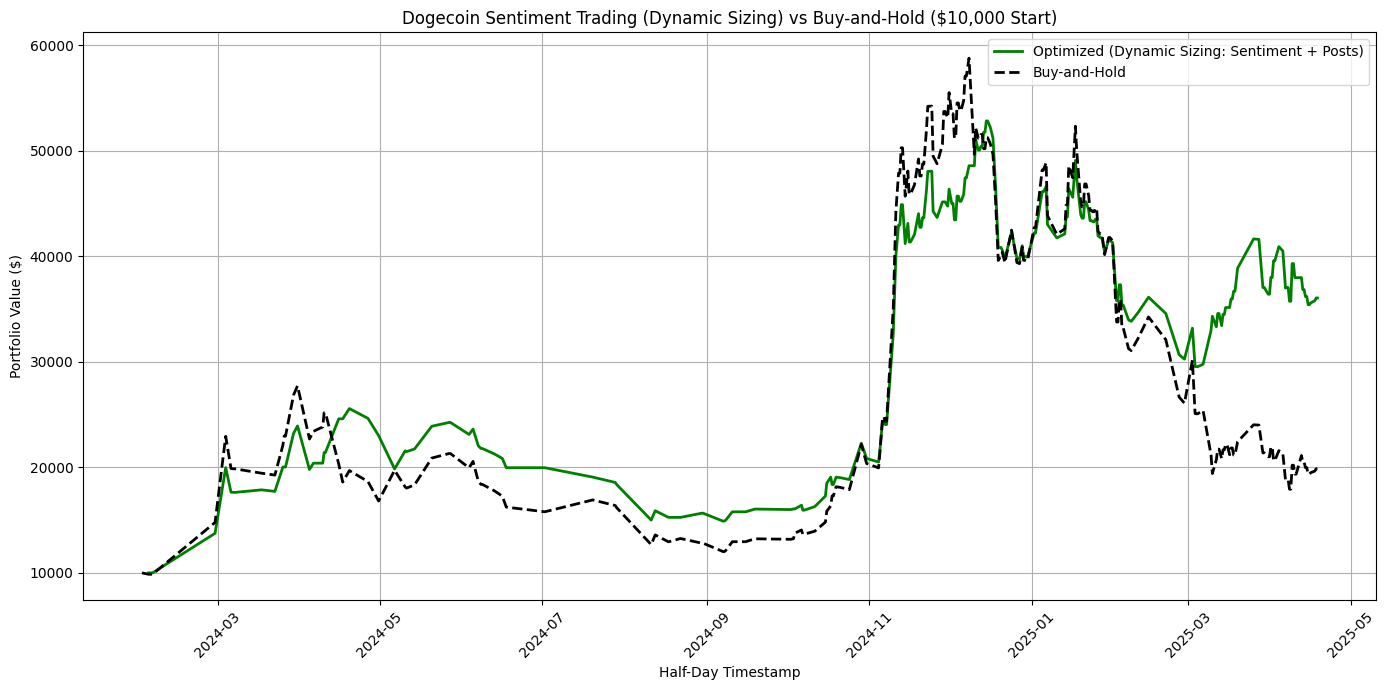

In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000
BASE_TRADE_PERCENT = 0.5
SENTIMENT_WEIGHT = 1.0
POSTS_WEIGHT = 0.5
OPTIMIZED_THRESHOLD = 0.05
OPTIMIZED_SMOOTHING_WINDOW = 2

# === LOAD DATA ===

# Load half-day sentiment
sentiment = pd.read_csv("half_day_sentiment.csv")

# Fix the half_day timestamp format
def fix_half_day(half_day_str):
    date_part, am_pm = half_day_str.split("_")
    if am_pm == "AM":
        return pd.to_datetime(date_part) + pd.Timedelta(hours=0)
    else:  # PM
        return pd.to_datetime(date_part) + pd.Timedelta(hours=12)

sentiment['half_day'] = sentiment['half_day'].apply(fix_half_day)

# Load Dogecoin DAILY prices
prices = pd.read_csv("doge_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Expand Dogecoin daily prices into half-days
half_day_prices = []
for _, row in prices.iterrows():
    am_time = row['date'] + pd.Timedelta(hours=0)
    pm_time = row['date'] + pd.Timedelta(hours=12)
    price = row['close']
    half_day_prices.append({'half_day': am_time, 'close': price})
    half_day_prices.append({'half_day': pm_time, 'close': price})

half_day_prices_df = pd.DataFrame(half_day_prices)

# === MERGE ===

df = pd.merge(sentiment, half_day_prices_df, on='half_day', how='inner')
df = df.sort_values('half_day').reset_index(drop=True)

# === CALCULATE BUY-AND-HOLD PORTFOLIO ===

valid_prices = df[df['close'] > 0].reset_index(drop=True)
initial_price = valid_prices['close'].iloc[0]
buy_and_hold_values = STARTING_PORTFOLIO * (valid_prices['close'] / initial_price)

# === SIMULATE OPTIMIZED TRADING STRATEGY (WITH FULL DYNAMIC SIZING) ===

df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=OPTIMIZED_SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > OPTIMIZED_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -OPTIMIZED_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

# Calculate average posts (for scaling)
average_num_posts = df['num_posts'].mean()

portfolio = STARTING_PORTFOLIO
position = None
entry_price = None
trade_size = 0
optimized_portfolio_values = []

for i in range(1, len(df)):
    today = df.loc[i]
    yesterday = df.loc[i-1]

    today_price = today['close']
    if today_price == 0 or pd.isna(today_price):
        optimized_portfolio_values.append(portfolio)
        continue

    signal = yesterday['signal']

    # === Dynamic Trade Size based on sentiment + posts ===
    sentiment_strength = abs(yesterday['smoothed_sentiment'])  # (e.g. 0.1, 0.3)
    post_strength = yesterday['num_posts'] / average_num_posts  # relative volume
    dynamic_trade_percent = BASE_TRADE_PERCENT * (1 + SENTIMENT_WEIGHT * sentiment_strength) * (1 + POSTS_WEIGHT * post_strength)
    dynamic_trade_percent = min(max(dynamic_trade_percent, 0.0), 1.0)  # Cap between 0%-100%

    if signal == 'LONG':
        if position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'LONG':
            trade_size = portfolio * dynamic_trade_percent
            position = 'LONG'
            entry_price = today_price

    elif signal == 'SHORT':
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'SHORT':
            trade_size = portfolio * dynamic_trade_percent
            position = 'SHORT'
            entry_price = today_price

    else:  # HOLD
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
        elif position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
        position = None
        entry_price = None

    if position == 'LONG' and entry_price is not None:
        unrealized = trade_size * (today_price / entry_price - 1)
    elif position == 'SHORT' and entry_price is not None:
        unrealized = trade_size * (1 - today_price / entry_price)
    else:
        unrealized = 0

    optimized_portfolio_values.append(portfolio + unrealized)

# === ALIGN DATES FOR PLOTTING ===

optimized_dates = df['half_day'][1:]
buy_and_hold_dates = valid_prices['half_day']

# === PLOT ===

plt.figure(figsize=(14,7))

plt.plot(optimized_dates, optimized_portfolio_values, label='Optimized (Dynamic Sizing: Sentiment + Posts)', color='green', linewidth=2)
plt.plot(buy_and_hold_dates, buy_and_hold_values, label='Buy-and-Hold', color='black', linestyle='--', linewidth=2)

plt.xlabel('Half-Day Timestamp')
plt.ylabel('Portfolio Value ($)')
plt.title('Dogecoin Sentiment Trading (Dynamic Sizing) vs Buy-and-Hold ($10,000 Start)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

***RL TIME***

In [421]:
import pandas as pd
import numpy as np

# === CONFIGURATION ===

TRAIN_END_DATE = pd.to_datetime("2025-03-31")  # Training until end of March 2025
TEST_START_DATE = pd.to_datetime("2025-04-01")  # Testing starts April 1st

# === LOAD DATA ===

# Load sentiment
sentiment = pd.read_csv("half_day_sentiment.csv")

# Fix the half_day timestamp format
def fix_half_day(half_day_str):
    date_part, am_pm = half_day_str.split("_")
    if am_pm == "AM":
        return pd.to_datetime(date_part) + pd.Timedelta(hours=0)
    else:  # PM
        return pd.to_datetime(date_part) + pd.Timedelta(hours=12)

sentiment['half_day'] = sentiment['half_day'].apply(fix_half_day)

# Load Dogecoin prices
prices = pd.read_csv("doge_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

# Expand daily prices into half-day (duplicating each day into AM and PM)
half_day_prices = []
for _, row in prices.iterrows():
    am_time = row['date'] + pd.Timedelta(hours=0)
    pm_time = row['date'] + pd.Timedelta(hours=12)
    price = row['close']
    half_day_prices.append({'half_day': am_time, 'close': price})
    half_day_prices.append({'half_day': pm_time, 'close': price})

half_day_prices_df = pd.DataFrame(half_day_prices)

# === MERGE ===

df = pd.merge(sentiment, half_day_prices_df, on='half_day', how='inner')
df = df.sort_values('half_day').reset_index(drop=True)

# Filter out any invalid prices
df = df[df['close'] > 0].reset_index(drop=True)

# === SPLIT INTO TRAINING / TESTING ===

train_df = df[df['half_day'] <= TRAIN_END_DATE].reset_index(drop=True)
test_df = df[df['half_day'] >= TEST_START_DATE].reset_index(drop=True)

train_df.to_csv("train_sentiment_prices.csv", index=False)
test_df.to_csv("test_sentiment_prices.csv", index=False)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")


Training samples: 218
Testing samples: 26


In [418]:
# === STATE DISCRETIZATION HELPERS ===

def discretize_sentiment(score):
    if score < -0.4:
        return 'very_negative'
    elif score < -0.1:
        return 'negative'
    elif score < 0.1:
        return 'neutral'
    elif score < 0.4:
        return 'positive'
    else:
        return 'very_positive'

def discretize_posts(num_posts, avg_posts):
    if num_posts < 0.75 * avg_posts:
        return 'low'
    elif num_posts > 1.25 * avg_posts:
        return 'high'
    else:
        return 'medium'

# === DEFINE STATE AND ACTION SPACE ===

# Discrete bins
sentiment_bins = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
post_bins = ['low', 'medium', 'high']

# State space
states = []
for sentiment_bin in sentiment_bins:
    for post_bin in post_bins:
        states.append((sentiment_bin, post_bin))

# Actions
# 0 = HOLD, 1 = LONG, 2 = SHORT
actions = [0, 1, 2]

# === INITIALIZE Q-TABLE ===

Q_table = {}
for state in states:
    Q_table[state] = np.zeros(len(actions))

print(f"Total number of states: {len(states)}")
print(f"Q-table shape: {len(Q_table)} states × {len(actions)} actions")

Total number of states: 15
Q-table shape: 15 states × 3 actions


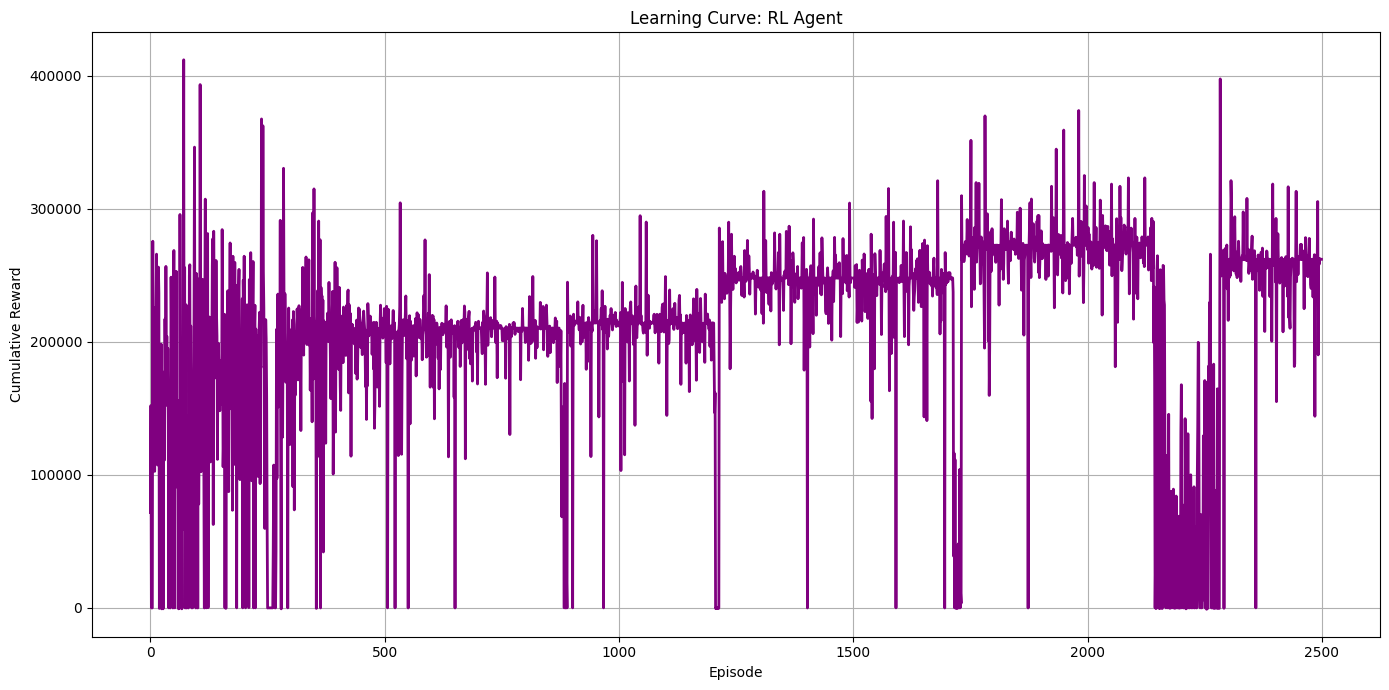

In [463]:
# === CONFIGURATION ===
STARTING_PORTFOLIO = 10000
TRADE_PERCENT = 0.5

ALPHA = 0.05
GAMMA = 0.99

EPSILON = 0.3
EPSILON_DECAY = 0.995
EPSILON_MIN = 0.01

NUM_EPISODES = 2500

# === LOAD DATA ===
train_df = pd.read_csv("train_sentiment_prices.csv")
train_df['half_day'] = pd.to_datetime(train_df['half_day'])

average_num_posts = train_df['num_posts'].mean()

# === DEFINE STATE SPACE ===
sentiment_bins = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
post_bins = ['low', 'medium', 'high']

states = []
for s in sentiment_bins:
    for p in post_bins:
        states.append((s, p))

actions = [0, 1, 2]  # HOLD, LONG, SHORT

# === INITIALIZE Q-TABLE ===
Q_table = {}
for state in states:
    Q_table[state] = np.zeros(len(actions))

# === HELPER FUNCTIONS ===
def discretize_sentiment(score):
    if score < -0.4:
        return 'very_negative'
    elif score < -0.1:
        return 'negative'
    elif score < 0.1:
        return 'neutral'
    elif score < 0.4:
        return 'positive'
    else:
        return 'very_positive'

def discretize_posts(num_posts, avg_posts):
    if num_posts < 0.75 * avg_posts:
        return 'low'
    elif num_posts > 1.25 * avg_posts:
        return 'high'
    else:
        return 'medium'

# === TRAINING LOOP ===
episode_rewards = []

STOP_LOSS_THRESHOLD = 0.10  # 10% loss triggers stop

for episode in range(NUM_EPISODES):
    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0.5 * portfolio
    cumulative_reward = 0
    starting_portfolio = portfolio  # Save for stop-loss checking

    for i in range(1, len(train_df)):
        today = train_df.loc[i]
        yesterday = train_df.loc[i-1]

        today_price = today['close']
        if today_price == 0 or pd.isna(today_price):
            continue

        # --- State Mapping ---
        sentiment_bin = discretize_sentiment(yesterday['avg_sentiment'])
        post_bin = discretize_posts(yesterday['num_posts'], average_num_posts)
        state = (sentiment_bin, post_bin)

        # --- Action Selection ---
        if np.random.rand() < EPSILON:
            action = np.random.choice([0, 1, 2])  # Explore
        else:
            action = np.argmax(Q_table[state])     # Exploit

        # --- Execute Action ---
        if action == 1:  # LONG
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * BASE_TRADE_PERCENT
                position = 'LONG'
                entry_price = today_price

        elif action == 2:  # SHORT
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * BASE_TRADE_PERCENT
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        # --- Reward Calculation ---
        reward = 1000 * (portfolio - starting_portfolio) / starting_portfolio
        cumulative_reward += reward

        # --- Q-Update ---
        next_sentiment_bin = discretize_sentiment(today['avg_sentiment'])
        next_post_bin = discretize_posts(today['num_posts'], average_num_posts)
        next_state = (next_sentiment_bin, next_post_bin)

        best_next_action = np.max(Q_table[next_state])
        Q_table[state][action] = (1 - ALPHA) * Q_table[state][action] + ALPHA * (reward + GAMMA * best_next_action)

        # --- Stop-loss Check ---
        if (portfolio < (1 - STOP_LOSS_THRESHOLD) * starting_portfolio):
            # Portfolio dropped too much → stop the episode early
            break

    # After episode
    episode_rewards.append(cumulative_reward)
    EPSILON = max(EPSILON_MIN, EPSILON * EPSILON_DECAY)

# === PLOT REWARDS ===
plt.figure(figsize=(14,7))
plt.plot(range(NUM_EPISODES), episode_rewards, color='purple', linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Learning Curve: RL Agent')
plt.grid(True)
plt.tight_layout()
plt.show()


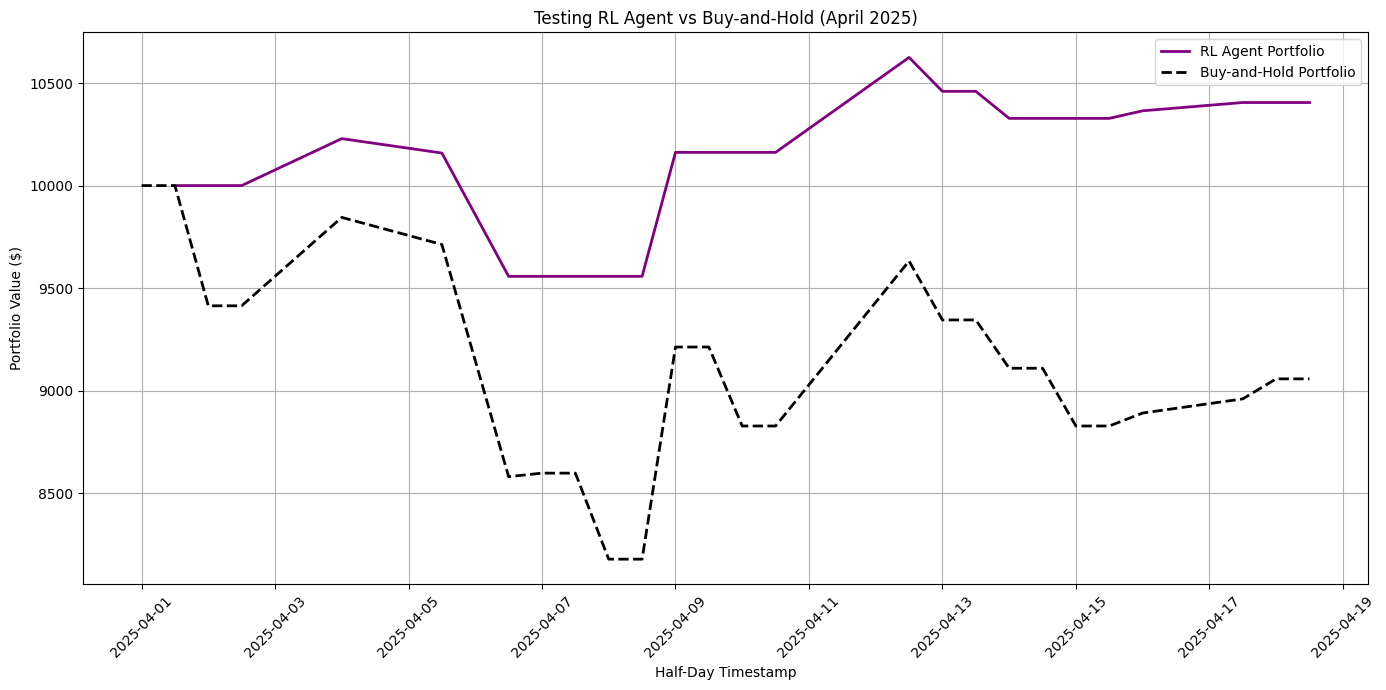

In [428]:
# === TESTING CONFIGURATION ===
STARTING_PORTFOLIO = 10000
BASE_TRADE_PERCENT = 0.5

# === Initialize ===
portfolio = STARTING_PORTFOLIO
position = None
entry_price = None
trade_size = 0
portfolio_values = []
dates = []

average_num_posts = test_df['num_posts'].mean()

# === Testing Loop ===
for i in range(1, len(test_df)):
    today = test_df.loc[i]
    yesterday = test_df.loc[i-1]

    today_price = today['close']
    if today_price == 0 or pd.isna(today_price):
        portfolio_values.append(portfolio)
        dates.append(today['half_day'])
        continue

    # --- State Mapping ---
    sentiment_bin = discretize_sentiment(yesterday['avg_sentiment'])
    post_bin = discretize_posts(yesterday['num_posts'], average_num_posts)
    state = (sentiment_bin, post_bin)

    # --- Always greedy action selection (no exploration) ---
    action = np.argmax(Q_table[state])

    # --- Execute action ---
    if action == 1:  # LONG
        if position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'LONG':
            trade_size = portfolio * BASE_TRADE_PERCENT
            position = 'LONG'
            entry_price = today_price

    elif action == 2:  # SHORT
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
            position = None
            entry_price = None
        if position != 'SHORT':
            trade_size = portfolio * BASE_TRADE_PERCENT
            position = 'SHORT'
            entry_price = today_price

    else:  # HOLD
        if position == 'LONG' and entry_price is not None:
            profit = trade_size * (today_price / entry_price - 1)
            portfolio += profit
        elif position == 'SHORT' and entry_price is not None:
            profit = trade_size * (1 - today_price / entry_price)
            portfolio += profit
        position = None
        entry_price = None

    # --- Calculate portfolio value ---
    if position == 'LONG' and entry_price is not None:
        unrealized = trade_size * (today_price / entry_price - 1)
    elif position == 'SHORT' and entry_price is not None:
        unrealized = trade_size * (1 - today_price / entry_price)
    else:
        unrealized = 0

    total_value = portfolio + unrealized
    portfolio_values.append(total_value)
    dates.append(today['half_day'])

# === BUY-AND-HOLD BASELINE ===

valid_prices = test_df[test_df['close'] > 0].reset_index(drop=True)
initial_price = valid_prices['close'].iloc[0]
buy_and_hold_values = STARTING_PORTFOLIO * (valid_prices['close'] / initial_price)
buy_and_hold_dates = valid_prices['half_day']

# === PLOT RESULTS ===

plt.figure(figsize=(14,7))
plt.plot(dates, portfolio_values, label='RL Agent Portfolio', color='purple', linewidth=2)
plt.plot(buy_and_hold_dates, buy_and_hold_values, label='Buy-and-Hold Portfolio', color='black', linestyle='--', linewidth=2)

plt.xlabel('Half-Day Timestamp')
plt.ylabel('Portfolio Value ($)')
plt.title('Testing RL Agent vs Buy-and-Hold (April 2025)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

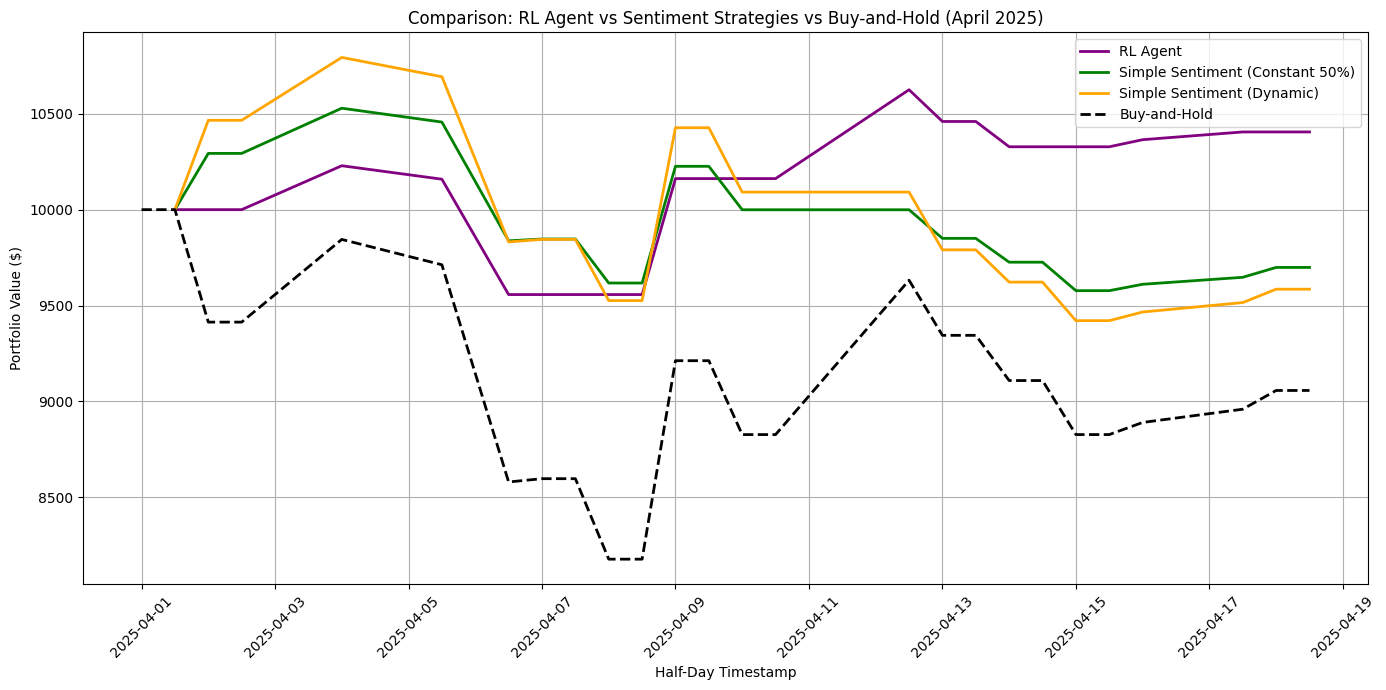

In [432]:
# === CONFIGURATION ===

OPTIMIZED_THRESHOLD = 0.05
OPTIMIZED_SMOOTHING_WINDOW = 2
STARTING_PORTFOLIO = 10000
BASE_TRADE_PERCENT = 0.5
SENTIMENT_WEIGHT = 1.0
POSTS_WEIGHT = 0.5

# === PREPARE DATA ===

# Assume test_df already loaded + contains ['half_day', 'close', 'avg_sentiment', 'num_posts']
# Also assume you already have: dates, portfolio_values (from RL agent), buy_and_hold_dates, buy_and_hold_values

test_df = test_df.copy()

# Smooth the sentiment
test_df['smoothed_sentiment'] = test_df['avg_sentiment'].rolling(window=OPTIMIZED_SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > OPTIMIZED_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -OPTIMIZED_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

test_df['signal'] = test_df['smoothed_sentiment'].apply(generate_signal)

average_num_posts = test_df['num_posts'].mean()

# === STRATEGY 1: Simple Constant 50% Sizing ===

portfolio_simple = STARTING_PORTFOLIO
position_simple = None
entry_price_simple = None
trade_size_simple = 0
simple_portfolio_values = []

for i in range(1, len(test_df)):
    today = test_df.loc[i]
    yesterday = test_df.loc[i-1]

    today_price = today['close']
    if today_price == 0 or pd.isna(today_price):
        simple_portfolio_values.append(portfolio_simple)
        continue

    signal = yesterday['signal']

    if signal == 'LONG':
        if position_simple == 'SHORT' and entry_price_simple is not None:
            profit = trade_size_simple * (1 - today_price / entry_price_simple)
            portfolio_simple += profit
            position_simple = None
            entry_price_simple = None
        if position_simple != 'LONG':
            trade_size_simple = portfolio_simple * BASE_TRADE_PERCENT
            position_simple = 'LONG'
            entry_price_simple = today_price

    elif signal == 'SHORT':
        if position_simple == 'LONG' and entry_price_simple is not None:
            profit = trade_size_simple * (today_price / entry_price_simple - 1)
            portfolio_simple += profit
            position_simple = None
            entry_price_simple = None
        if position_simple != 'SHORT':
            trade_size_simple = portfolio_simple * BASE_TRADE_PERCENT
            position_simple = 'SHORT'
            entry_price_simple = today_price

    else:  # HOLD
        if position_simple == 'LONG' and entry_price_simple is not None:
            profit = trade_size_simple * (today_price / entry_price_simple - 1)
            portfolio_simple += profit
        elif position_simple == 'SHORT' and entry_price_simple is not None:
            profit = trade_size_simple * (1 - today_price / entry_price_simple)
            portfolio_simple += profit
        position_simple = None
        entry_price_simple = None

    if position_simple == 'LONG' and entry_price_simple is not None:
        unrealized = trade_size_simple * (today_price / entry_price_simple - 1)
    elif position_simple == 'SHORT' and entry_price_simple is not None:
        unrealized = trade_size_simple * (1 - today_price / entry_price_simple)
    else:
        unrealized = 0

    simple_portfolio_values.append(portfolio_simple + unrealized)

# === STRATEGY 2: Dynamic Sizing (Sentiment Strength + Post Volume) ===

portfolio_dynamic = STARTING_PORTFOLIO
position_dynamic = None
entry_price_dynamic = None
trade_size_dynamic = 0
dynamic_portfolio_values = []

for i in range(1, len(test_df)):
    today = test_df.loc[i]
    yesterday = test_df.loc[i-1]

    today_price = today['close']
    if today_price == 0 or pd.isna(today_price):
        dynamic_portfolio_values.append(portfolio_dynamic)
        continue

    signal = yesterday['signal']

    sentiment_strength = abs(yesterday['smoothed_sentiment'])
    post_strength = yesterday['num_posts'] / average_num_posts

    dynamic_trade_percent = BASE_TRADE_PERCENT * (1 + SENTIMENT_WEIGHT * sentiment_strength) * (1 + POSTS_WEIGHT * post_strength)
    dynamic_trade_percent = min(max(dynamic_trade_percent, 0.0), 1.0)  # Clamp 0-1
    dynamic_trade_size = portfolio_dynamic * dynamic_trade_percent

    if signal == 'LONG':
        if position_dynamic == 'SHORT' and entry_price_dynamic is not None:
            profit = trade_size_dynamic * (1 - today_price / entry_price_dynamic)
            portfolio_dynamic += profit
            position_dynamic = None
            entry_price_dynamic = None
        if position_dynamic != 'LONG':
            trade_size_dynamic = dynamic_trade_size
            position_dynamic = 'LONG'
            entry_price_dynamic = today_price

    elif signal == 'SHORT':
        if position_dynamic == 'LONG' and entry_price_dynamic is not None:
            profit = trade_size_dynamic * (today_price / entry_price_dynamic - 1)
            portfolio_dynamic += profit
            position_dynamic = None
            entry_price_dynamic = None
        if position_dynamic != 'SHORT':
            trade_size_dynamic = dynamic_trade_size
            position_dynamic = 'SHORT'
            entry_price_dynamic = today_price

    else:  # HOLD
        if position_dynamic == 'LONG' and entry_price_dynamic is not None:
            profit = trade_size_dynamic * (today_price / entry_price_dynamic - 1)
            portfolio_dynamic += profit
        elif position_dynamic == 'SHORT' and entry_price_dynamic is not None:
            profit = trade_size_dynamic * (1 - today_price / entry_price_dynamic)
            portfolio_dynamic += profit
        position_dynamic = None
        entry_price_dynamic = None

    if position_dynamic == 'LONG' and entry_price_dynamic is not None:
        unrealized = trade_size_dynamic * (today_price / entry_price_dynamic - 1)
    elif position_dynamic == 'SHORT' and entry_price_dynamic is not None:
        unrealized = trade_size_dynamic * (1 - today_price / entry_price_dynamic)
    else:
        unrealized = 0

    dynamic_portfolio_values.append(portfolio_dynamic + unrealized)

# === PLOT COMPARISON ===

plt.figure(figsize=(14,7))

plt.plot(dates, portfolio_values, label='RL Agent', color='purple', linewidth=2)
plt.plot(test_df['half_day'][1:], simple_portfolio_values, label='Simple Sentiment (Constant 50%)', color='green', linewidth=2)
plt.plot(test_df['half_day'][1:], dynamic_portfolio_values, label='Simple Sentiment (Dynamic)', color='orange', linewidth=2)
plt.plot(buy_and_hold_dates, buy_and_hold_values, label='Buy-and-Hold', color='black', linestyle='--', linewidth=2)

plt.xlabel('Half-Day Timestamp')
plt.ylabel('Portfolio Value ($)')
plt.title('Comparison: RL Agent vs Sentiment Strategies vs Buy-and-Hold (April 2025)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [496]:
import praw
import pandas as pd
import re
import time
from datetime import datetime

# === CONFIGURATION ===

# Reddit Authentication
REDDIT_CLIENT_ID = "suCjVen6MTRiU9E88cqRAg"
REDDIT_CLIENT_SECRET = "UiP81w6C1qyenfZzJ0asiegtJlQtZA"
REDDIT_USER_AGENT = "ECE473 Final Project"

reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT,
)

# Subreddits to scrape (more DOGE-related)
SUBREDDITS = ["CryptoCurrency", "dogecoin", "CryptoMarkets", "SatoshiStreetBets", "CryptoMoonShots"]

# Regex pattern to match Dogecoin mentions
DOGE_REGEX = re.compile(r"(?i)\b(doge\s*coin|dogecoin|\$doge)\b")

# Output CSV
OUTPUT_FILE = "reddit_dogecoin_filtered.csv"

# Target Time Window
START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2025, 4, 19)

# Sleep time between API calls
SLEEP_TIME = 0.5  # seconds

# === HELPER FUNCTIONS ===

def match_dogecoin(text):
    """Check if text matches Dogecoin regex."""
    if text:
        return bool(DOGE_REGEX.search(text))
    return False

def utc_to_datetime(utc_timestamp):
    """Convert UTC timestamp to datetime object."""
    return datetime.utcfromtimestamp(utc_timestamp)

def is_within_date_range(utc_timestamp):
    """Check if the post/comment is within the target date window."""
    post_time = utc_to_datetime(utc_timestamp)
    return START_DATE <= post_time <= END_DATE

def extract_post_data(post):
    """Extract fields from a Reddit post."""
    return {
        "source": "post",
        "parent_id": post.id,
        "subreddit": post.subreddit.display_name,
        "author": str(post.author),
        "score": post.score,
        "created_utc": utc_to_datetime(post.created_utc),
        "text": (post.title or "") + " " + (post.selftext or ""),
        "permalink": f"https://reddit.com{post.permalink}"
    }

def extract_comment_data(comment, parent_id):
    """Extract fields from a Reddit comment."""
    return {
        "source": "comment",
        "parent_id": parent_id,
        "subreddit": comment.subreddit.display_name,
        "author": str(comment.author),
        "score": comment.score,
        "created_utc": utc_to_datetime(comment.created_utc),
        "text": comment.body,
        "permalink": f"https://reddit.com{comment.permalink}" if hasattr(comment, "permalink") else None
    }

# === MAIN SCRAPER ===

def main():
    all_data = []

    for subreddit_name in SUBREDDITS:
        print(f"Searching subreddit: {subreddit_name}")
        subreddit = reddit.subreddit(subreddit_name)

        # Start fetching newest posts
        for post in subreddit.search("dogecoin OR \"doge coin\" OR $doge", sort="new", limit=None):
            post_time = utc_to_datetime(post.created_utc)

            # Stop if we went before the START_DATE
            if post_time < START_DATE:
                print(f"Reached post before start date {START_DATE.date()}. Stopping for subreddit {subreddit_name}.")
                break

            if not is_within_date_range(post.created_utc):
                continue

            post_text = (post.title or "") + " " + (post.selftext or "")
            if match_dogecoin(post_text):
                all_data.append(extract_post_data(post))

                try:
                    post.comments.replace_more(limit=0)
                    for comment in post.comments.list():
                        if is_within_date_range(comment.created_utc) and match_dogecoin(comment.body):
                            all_data.append(extract_comment_data(comment, parent_id=post.id))
                except Exception as e:
                    print(f"Error fetching comments: {e}")

            time.sleep(SLEEP_TIME)

    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Saved {len(df)} records to {OUTPUT_FILE}")

# === ENTRY POINT ===

if __name__ == "__main__":
    main()


Searching subreddit: CryptoCurrency
Searching subreddit: dogecoin
Searching subreddit: CryptoMarkets
Searching subreddit: SatoshiStreetBets
Reached post before start date 2024-01-01. Stopping for subreddit SatoshiStreetBets.
Searching subreddit: CryptoMoonShots
Saved 624 records to reddit_dogecoin_filtered.csv


Saved 950 half-days of DogeCoin prices to doge_prices_halfday.csv


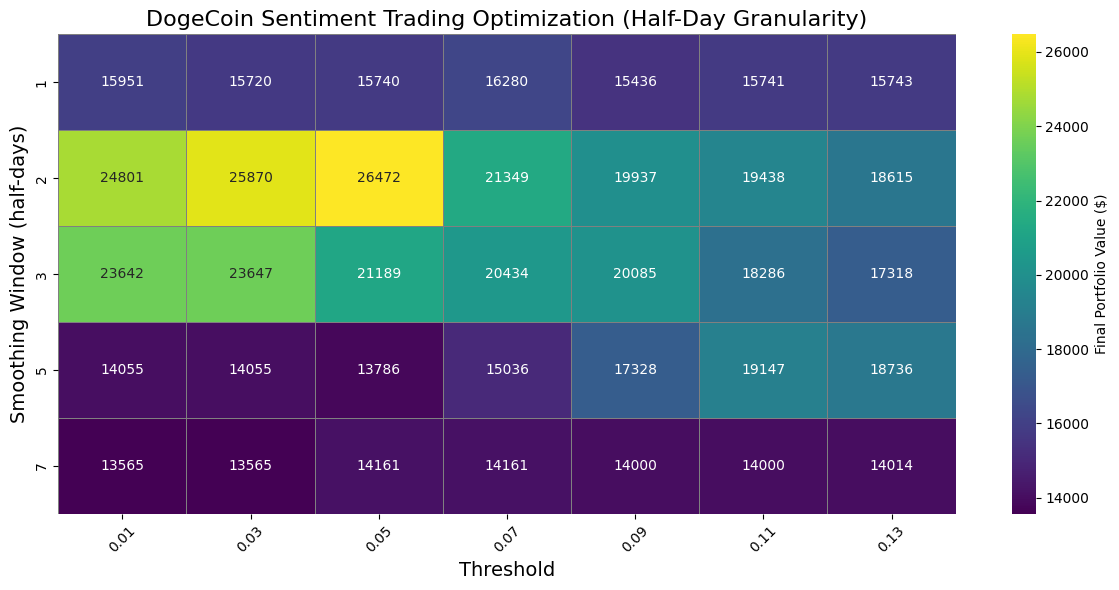

In [498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime, timedelta

# === CONFIGURATION ===
API_KEY = "5a69a69b336064e8f6c950f66d17ef5e08c727162f1c06e70e17722f8af024ef"

FSYM = "DOGE"
TSYM = "USDT"

START_DATE = datetime(2024, 1, 1)
END_DATE = datetime(2025, 4, 19)

# Calculate number of days
days_diff = (END_DATE - START_DATE).days

# === GET DAILY PRICES ===
url = "https://min-api.cryptocompare.com/data/v2/histoday"
params = {
    "fsym": FSYM,
    "tsym": TSYM,
    "limit": days_diff,
    "toTs": int(END_DATE.timestamp()),
    "api_key": API_KEY
}

response = requests.get(url, params=params)
data = response.json()

if data['Response'] != 'Success':
    raise Exception(f"Failed to fetch prices: {data}")

price_data = data['Data']['Data']
df_prices_daily = pd.DataFrame(price_data)
df_prices_daily['date'] = pd.to_datetime(df_prices_daily['time'], unit='s')
df_prices_daily = df_prices_daily[['date', 'close']]

# === EXPAND DAILY PRICES TO HALF-DAY PRICES ===

# Duplicate each row into AM and PM
df_prices_halfday = pd.DataFrame({
    'half_day': [d.strftime("%Y-%m-%d_AM") for d in df_prices_daily['date']] + [d.strftime("%Y-%m-%d_PM") for d in df_prices_daily['date']],
    'close': list(df_prices_daily['close']) + list(df_prices_daily['close'])  # Same price for both halves
})

df_prices_halfday = df_prices_halfday.sort_values('half_day').reset_index(drop=True)

# Save
df_prices_halfday.to_csv("doge_prices_halfday.csv", index=False)
print(f"Saved {len(df_prices_halfday)} half-days of DogeCoin prices to doge_prices_halfday.csv")

# === LOAD HALF-DAY SENTIMENT ===
df_sentiment = pd.read_csv("half_day_sentiment.csv")

# Merge
df = pd.merge(df_sentiment, df_prices_halfday, on='half_day', how='inner')
df = df.sort_values('half_day').reset_index(drop=True)

# === OPTIMIZATION ===
STARTING_PORTFOLIO = 10000
TRADE_PERCENT = 0.5

smoothing_windows = [1, 2, 3, 5, 7]
thresholds = np.arange(0.01, 0.15, 0.02)

results = []

for window in smoothing_windows:
    for threshold in thresholds:
        portfolio = STARTING_PORTFOLIO
        position = None
        entry_price = None
        trade_size = 0

        df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=window, min_periods=1).mean()

        def generate_signal(smoothed_sentiment):
            if smoothed_sentiment > threshold:
                return 'LONG'
            elif smoothed_sentiment < -threshold:
                return 'SHORT'
            else:
                return 'HOLD'

        df['signal'] = df['smoothed_sentiment'].apply(generate_signal)

        for i in range(1, len(df)):
            today = df.loc[i]
            yesterday = df.loc[i-1]

            today_price = today['close']
            if today_price == 0 or pd.isna(today_price):
                continue

            signal = yesterday['signal']

            if signal == 'LONG':
                if position == 'SHORT' and entry_price is not None:
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                    position = None
                    entry_price = None
                if position != 'LONG':
                    trade_size = portfolio * TRADE_PERCENT
                    position = 'LONG'
                    entry_price = today_price

            elif signal == 'SHORT':
                if position == 'LONG' and entry_price is not None:
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                    position = None
                    entry_price = None
                if position != 'SHORT':
                    trade_size = portfolio * TRADE_PERCENT
                    position = 'SHORT'
                    entry_price = today_price

            else:  # HOLD
                if position == 'LONG' and entry_price is not None:
                    profit = trade_size * (today_price / entry_price - 1)
                    portfolio += profit
                elif position == 'SHORT' and entry_price is not None:
                    profit = trade_size * (1 - today_price / entry_price)
                    portfolio += profit
                position = None
                entry_price = None

        # Close any final open position
        if position == 'LONG' and entry_price is not None:
            final_price = df.loc[len(df)-1]['close']
            profit = trade_size * (final_price / entry_price - 1)
            portfolio += profit
        elif position == 'SHORT' and entry_price is not None:
            final_price = df.loc[len(df)-1]['close']
            profit = trade_size * (1 - final_price / entry_price)
            portfolio += profit

        results.append({
            'smoothing_window': window,
            'threshold': threshold,
            'final_portfolio': portfolio
        })

# === RESULTS ===
results_df = pd.DataFrame(results)

pivot_table = results_df.pivot(index='smoothing_window', columns='threshold', values='final_portfolio')

# === PLOT ===
plt.figure(figsize=(12,6))
sns.heatmap(pivot_table, 
            annot=True, fmt=".0f", cmap="viridis",
            linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Final Portfolio Value ($)'})

plt.title('DogeCoin Sentiment Trading Optimization (Half-Day Granularity)', fontsize=16)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Smoothing Window (half-days)', fontsize=14)

plt.xticks(ticks=np.arange(len(pivot_table.columns)) + 0.5, 
           labels=[f"{x:.2f}" for x in pivot_table.columns], rotation=45)
plt.yticks(ticks=np.arange(len(pivot_table.index)) + 0.5, 
           labels=pivot_table.index)

plt.tight_layout()
plt.show()


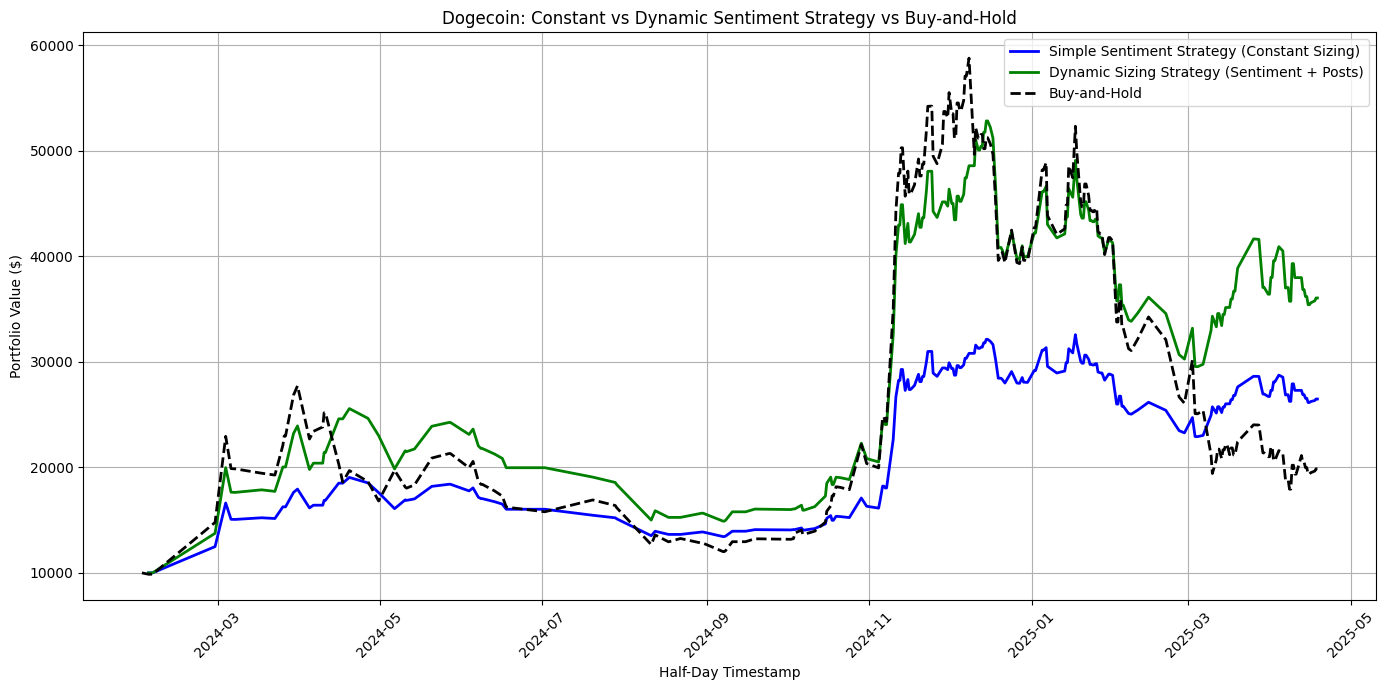

In [506]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURATION ===

STARTING_PORTFOLIO = 10000
BASE_TRADE_PERCENT = 0.5
SENTIMENT_WEIGHT = 1.0
POSTS_WEIGHT = 0.5
OPTIMIZED_THRESHOLD = 0.05
OPTIMIZED_SMOOTHING_WINDOW = 2

# === LOAD DATA ===

# Load half-day sentiment
sentiment = pd.read_csv("half_day_sentiment.csv")

def fix_half_day(half_day_str):
    date_part, am_pm = half_day_str.split("_")
    return pd.to_datetime(date_part) + pd.Timedelta(hours=0 if am_pm == "AM" else 12)

sentiment['half_day'] = sentiment['half_day'].apply(fix_half_day)

# Load daily prices and convert to half-day resolution
prices = pd.read_csv("doge_prices.csv")
prices['date'] = pd.to_datetime(prices['date'])

half_day_prices = []
for _, row in prices.iterrows():
    price = row['close']
    half_day_prices.extend([
        {'half_day': row['date'] + pd.Timedelta(hours=0), 'close': price},
        {'half_day': row['date'] + pd.Timedelta(hours=12), 'close': price}
    ])
half_day_prices_df = pd.DataFrame(half_day_prices)

# Merge data
df = pd.merge(sentiment, half_day_prices_df, on='half_day', how='inner').sort_values('half_day').reset_index(drop=True)

# === SIGNAL GENERATION ===

df['smoothed_sentiment'] = df['avg_sentiment'].rolling(window=OPTIMIZED_SMOOTHING_WINDOW, min_periods=1).mean()

def generate_signal(smoothed_sentiment):
    if smoothed_sentiment > OPTIMIZED_THRESHOLD:
        return 'LONG'
    elif smoothed_sentiment < -OPTIMIZED_THRESHOLD:
        return 'SHORT'
    else:
        return 'HOLD'

df['signal'] = df['smoothed_sentiment'].apply(generate_signal)
average_num_posts = df['num_posts'].mean()

# === FUNCTION: Simulate Strategy ===

def simulate_strategy(dynamic_sizing=False):
    portfolio = STARTING_PORTFOLIO
    position = None
    entry_price = None
    trade_size = 0
    values = []

    for i in range(1, len(df)):
        today = df.loc[i]
        yesterday = df.loc[i - 1]
        today_price = today['close']

        if today_price == 0 or pd.isna(today_price):
            values.append(portfolio)
            continue

        signal = yesterday['signal']

        if dynamic_sizing:
            sentiment_strength = abs(yesterday['smoothed_sentiment'])
            post_strength = yesterday['num_posts'] / average_num_posts
            trade_percent = BASE_TRADE_PERCENT * (1 + SENTIMENT_WEIGHT * sentiment_strength) * (1 + POSTS_WEIGHT * post_strength)
            trade_percent = min(max(trade_percent, 0.0), 1.0)
        else:
            trade_percent = BASE_TRADE_PERCENT

        if signal == 'LONG':
            if position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'LONG':
                trade_size = portfolio * trade_percent
                position = 'LONG'
                entry_price = today_price

        elif signal == 'SHORT':
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
                position = None
                entry_price = None
            if position != 'SHORT':
                trade_size = portfolio * trade_percent
                position = 'SHORT'
                entry_price = today_price

        else:  # HOLD
            if position == 'LONG' and entry_price is not None:
                profit = trade_size * (today_price / entry_price - 1)
                portfolio += profit
            elif position == 'SHORT' and entry_price is not None:
                profit = trade_size * (1 - today_price / entry_price)
                portfolio += profit
            position = None
            entry_price = None

        # Unrealized gain/loss
        if position == 'LONG' and entry_price is not None:
            unrealized = trade_size * (today_price / entry_price - 1)
        elif position == 'SHORT' and entry_price is not None:
            unrealized = trade_size * (1 - today_price / entry_price)
        else:
            unrealized = 0

        values.append(portfolio + unrealized)

    return values

# === RUN SIMULATIONS ===

dynamic_values = simulate_strategy(dynamic_sizing=True)
constant_values = simulate_strategy(dynamic_sizing=False)

valid_prices = df[df['close'] > 0].reset_index(drop=True)
initial_price = valid_prices['close'].iloc[0]
buy_and_hold_values = STARTING_PORTFOLIO * (valid_prices['close'] / initial_price)

# === PLOT ===

plt.figure(figsize=(14, 7))

plt.plot(df['half_day'][1:], constant_values, label='Simple Sentiment Strategy (Constant Sizing)', color='blue', linewidth=2)
plt.plot(df['half_day'][1:], dynamic_values, label='Dynamic Sizing Strategy (Sentiment + Posts)', color='green', linewidth=2)
plt.plot(valid_prices['half_day'], buy_and_hold_values, label='Buy-and-Hold', color='black', linestyle='--', linewidth=2)

plt.xlabel('Half-Day Timestamp')
plt.ylabel('Portfolio Value ($)')
plt.title('Dogecoin: Constant vs Dynamic Sentiment Strategy vs Buy-and-Hold')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
